## Library

In [108]:
import pandas as pd

from pathlib import Path

import pandas as pd
import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import shap
import numpy as np


PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "EVI and Crop Land" / "EVI 2010-2025"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [ ]:
def preprocess_evi(evi_file: str | Path) -> pd.DataFrame:
    """Preprocess EVI CSV file."""
    evi_df = pd.read_csv(evi_file)

    metadata_cols = [
        col for col in evi_df.columns if "EVI" not in col and "system:index" not in col
    ]
    evi_df = (
        evi_df.rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
        .drop(columns=["system:index"])
        .melt(
            id_vars=metadata_cols,
            var_name="band_date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            ),
        )
    )
    return evi_df


def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(l: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in l:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels

## Data

In [86]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

In [87]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

evi_adm0_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 0"
                / "MIMU"
                / f"myanmar_adm0_evi_stats_{year}.csv"
            )
            for year in range(2010, 2026)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["date"])
    .reset_index(drop=True)
    .set_index("date")
)
evi_adm1_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 1"
                / "MIMU"
                / f"myanmar_adm1_evi_stats_{year}_batch{batch}.csv"
            )
            for year in range(2010, 2026)
            for batch in range(1, 4)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["ST", "date"])
    .reset_index(drop=True)
    .rename(columns={"ST": "adm1_name"})
    .set_index("date")
)

In [88]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [89]:
no2_adm3_raw = pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv").rename(
    columns={"start_date": "date"}
)
no2_industrial_raw = pd.read_csv(
    DATA_PATH / "AirPollution" / "myanmar_no2_industrial_zones.csv"
)

no2_adm3 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm3_en": "adm3_name"})
    .groupby(["adm3_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm1 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm0 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

In [7]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        agriculture_pct=lambda df: df["agriculture"] / df["agriculture"].sum(),
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

In [8]:
gdp_agri_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Agriculture" & economic_activity == "Agriculture"')
    .rename(columns={"gdp": "gdp_agri"})
    .filter(["gdp_agri"])
)

gdp_mft_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Industry"')
    .groupby(pd.Grouper(freq="QS"))
    .agg({"gdp": "sum"})
    .rename(columns={"gdp": "gdp_mft"})
    .filter(["gdp_mft"])
)

evi_adm0 = (
    evi_adm0_raw.groupby(pd.Grouper(freq="QS")).agg({"EVI": "median"}).pipe(clean_names)
)

evi_adm1 = (
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"EVI": "median"})
    .pipe(clean_names)
)

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/4149836941.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/4149836941.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [9]:
gdp_agri_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_agri_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_agri_quarterly_adm1 = (
    gdp_agri_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "agriculture_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_agri_quarterly.reset_index(), on="date", how="left")
    .rename(columns={"gdp_agri": "gdp_agri_total"})
    .assign(gdp_agri=lambda df: df["gdp_agri_total"] * df["agriculture_pct"])
    .set_index(["adm1_name", "date"])
    .filter(["gdp_agri"])
)

In [10]:
gdp_mft_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_mft_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_mft_quarterly_adm1 = (
    gdp_mft_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_mft_quarterly.reset_index(), on="date", how="left")
    .rename(columns={"gdp_mft": "gdp_mft_total"})
    .assign(gdp_mft=lambda df: df["gdp_mft_total"] * df["industry_pct"])
    .set_index(["adm1_name", "date"])
    .filter(["gdp_mft"])
)

## Admin Level 0 Analysis

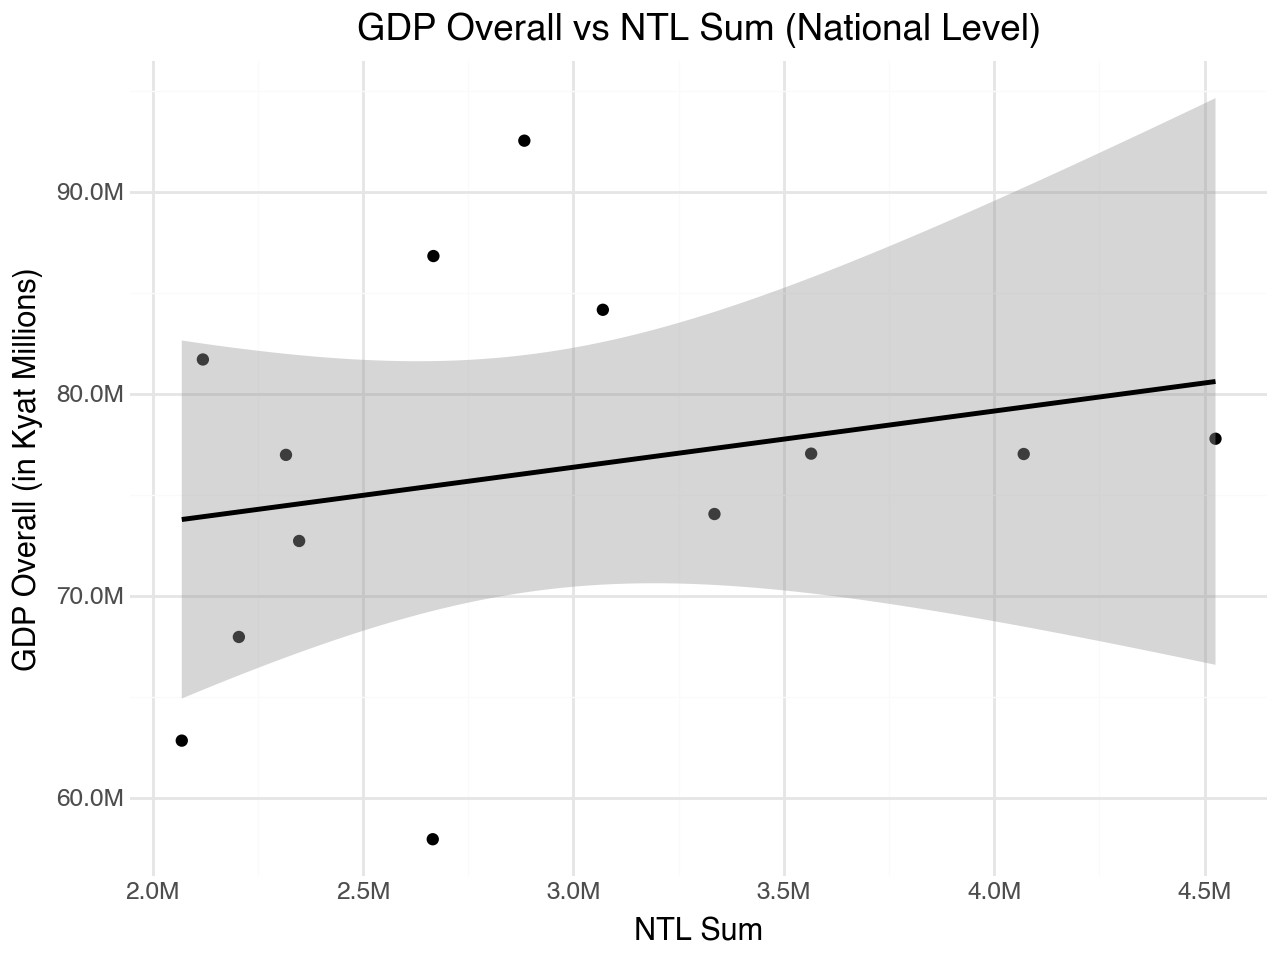

In [92]:
ntl_adm0_annual = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

(
    gdp_overall.join(ntl_adm0_annual, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_overall")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP Overall vs NTL Sum (National Level)",
        x="NTL Sum",
        y="GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

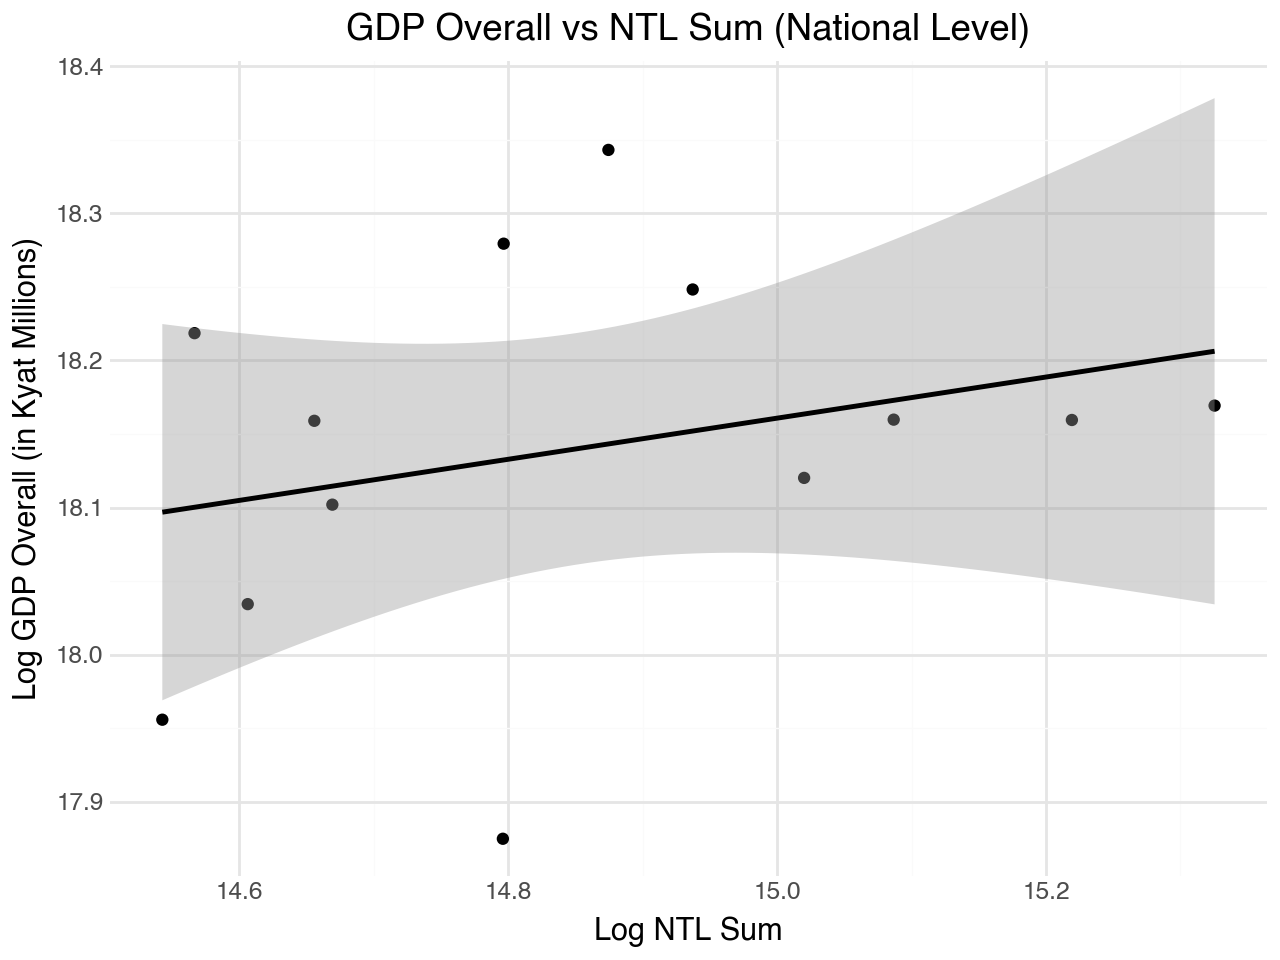

In [116]:
ntl_adm0_annual = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

(
    gdp_overall.join(ntl_adm0_annual, how="inner")
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NTL Sum (National Level)",
        x="Log NTL Sum",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/3952778215.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


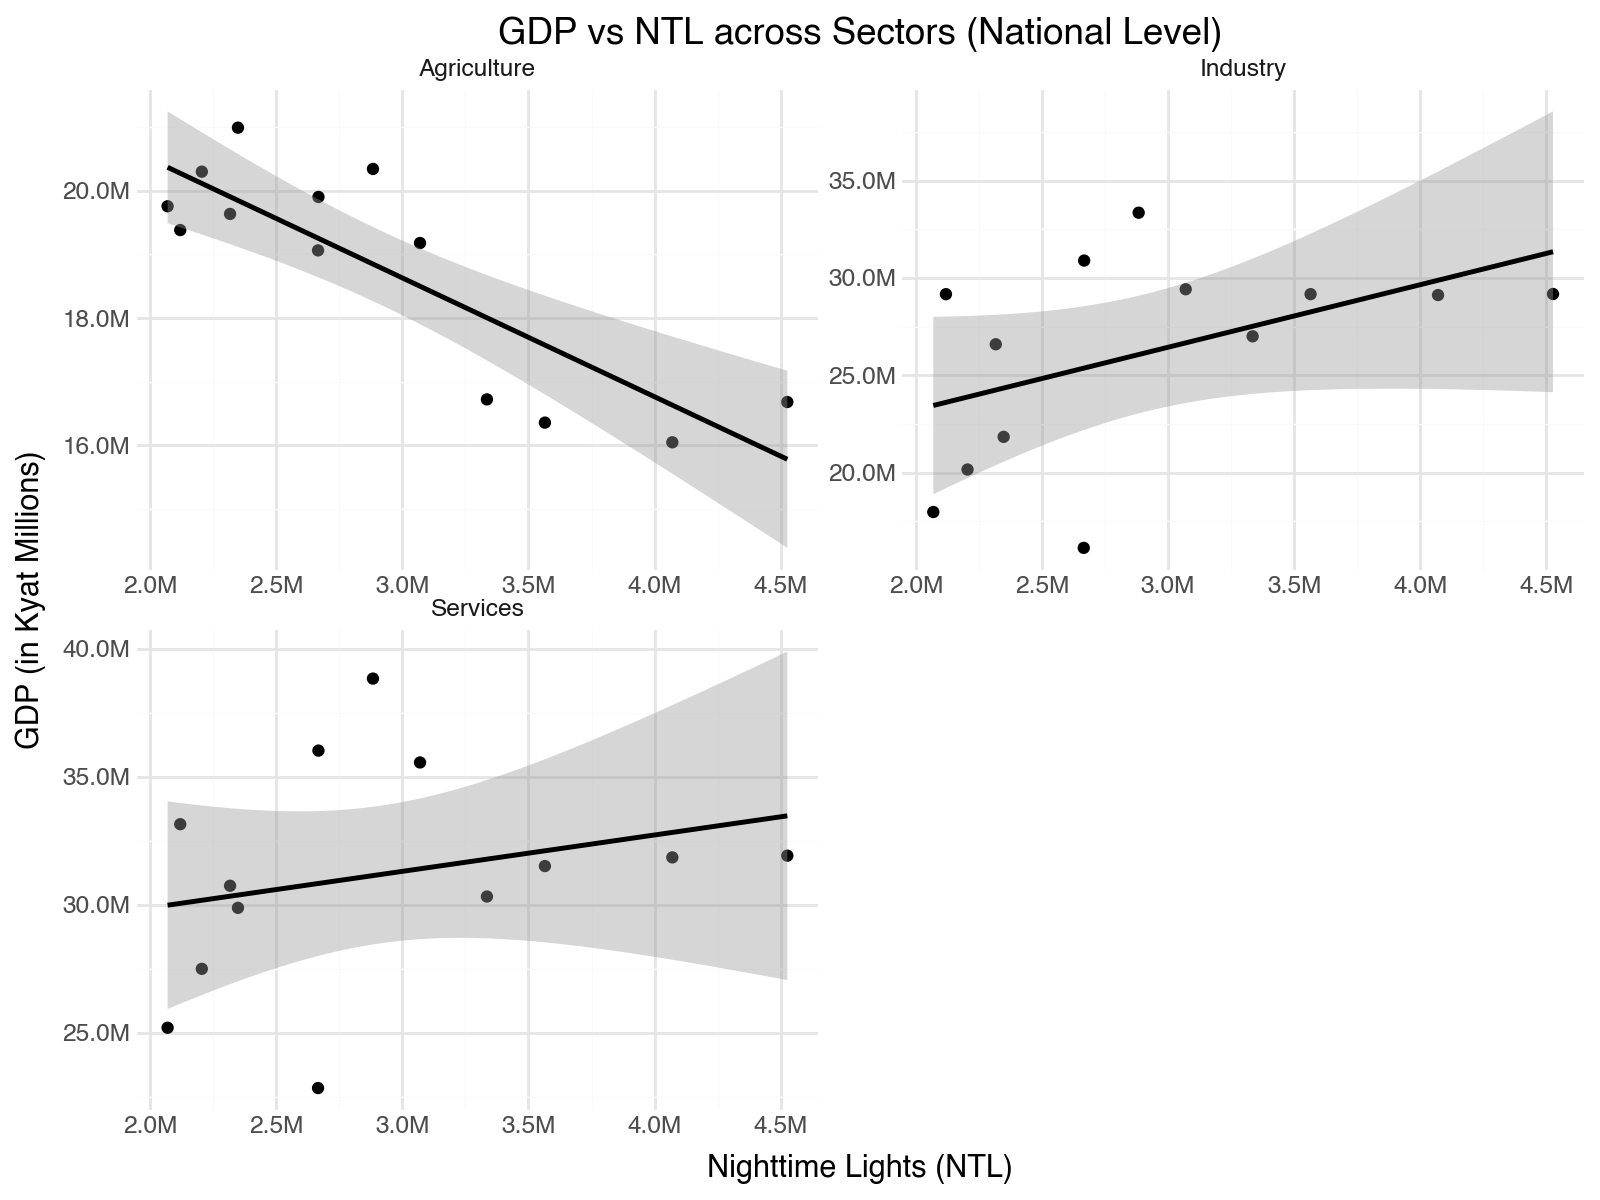

In [118]:
gdp_annual = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .groupby(["sub_group", pd.Grouper(freq="YS")])
    .agg({"gdp": "sum"})
)

(
    gdp_annual.join(ntl_adm0_annual, how="inner")
    .reset_index()
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        x="Nighttime Lights (NTL)",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

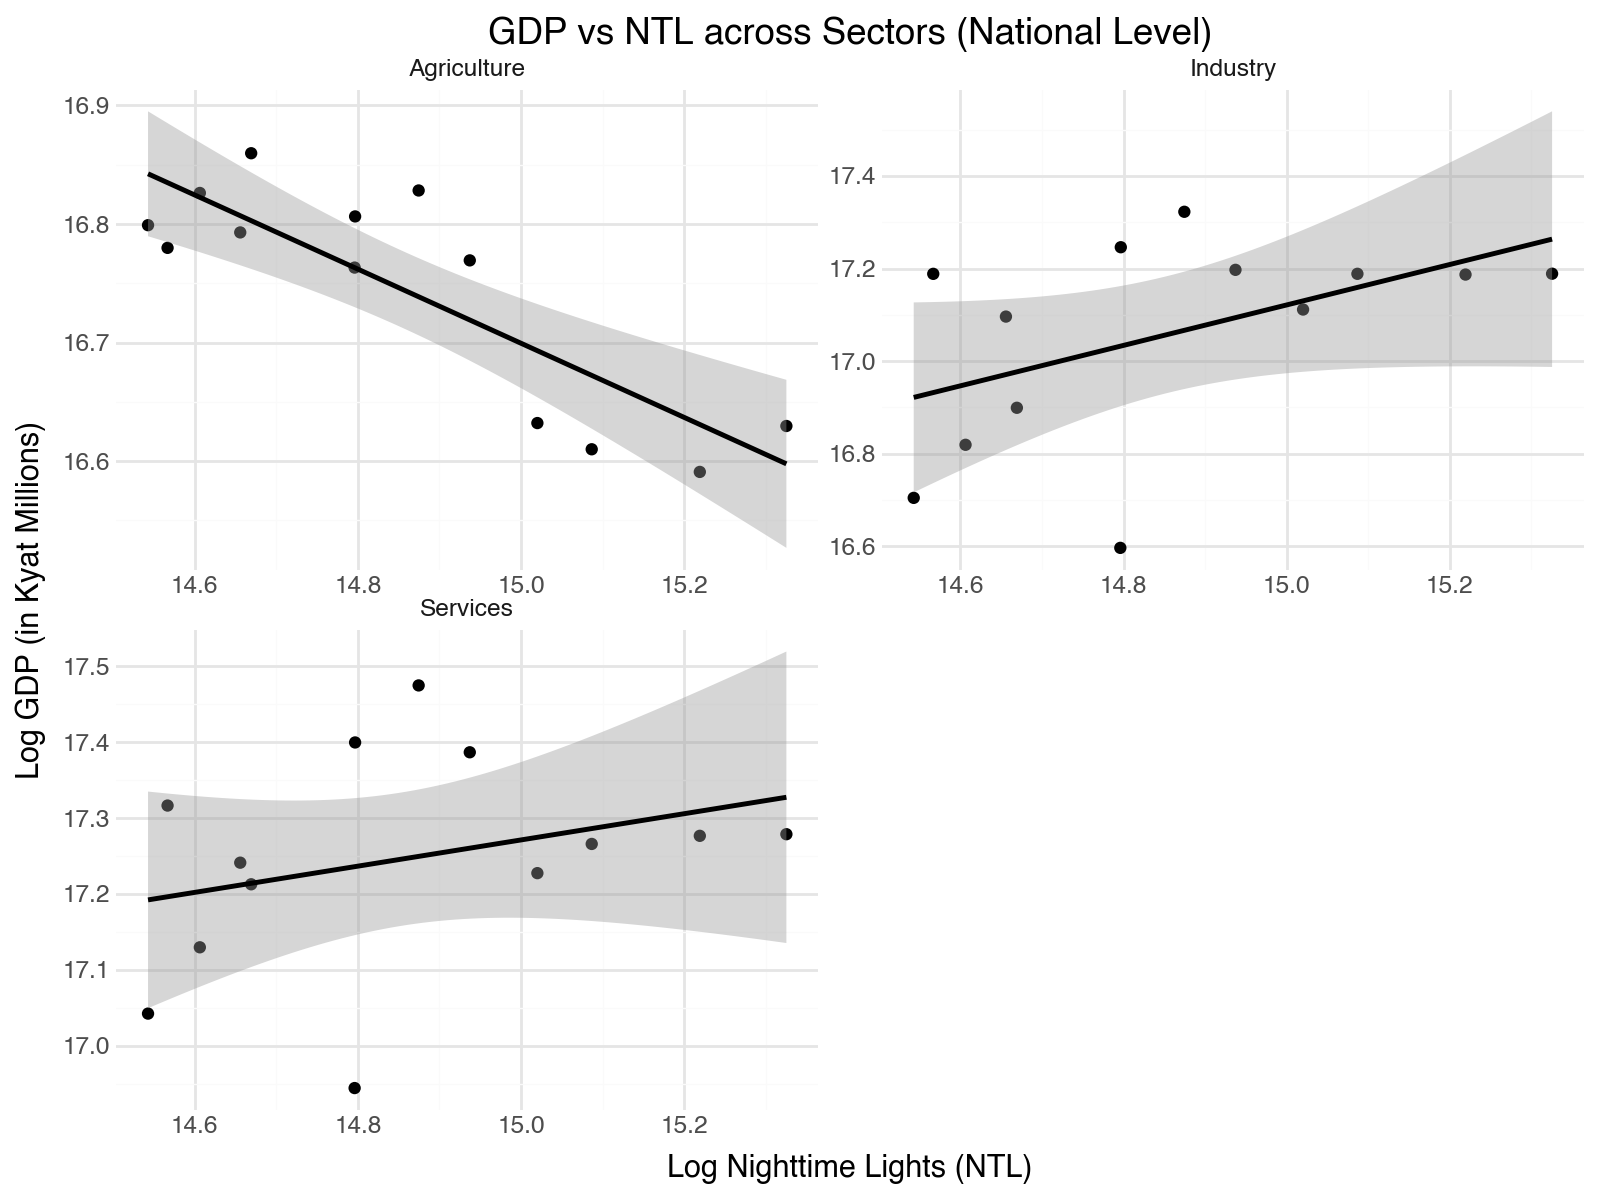

In [119]:
(
    gdp_annual.join(ntl_adm0_annual, how="inner")
    .reset_index()
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_log=lambda df: np.log1p(df["gdp"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        x="Log Nighttime Lights (NTL)",
        y="Log GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/423323021.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


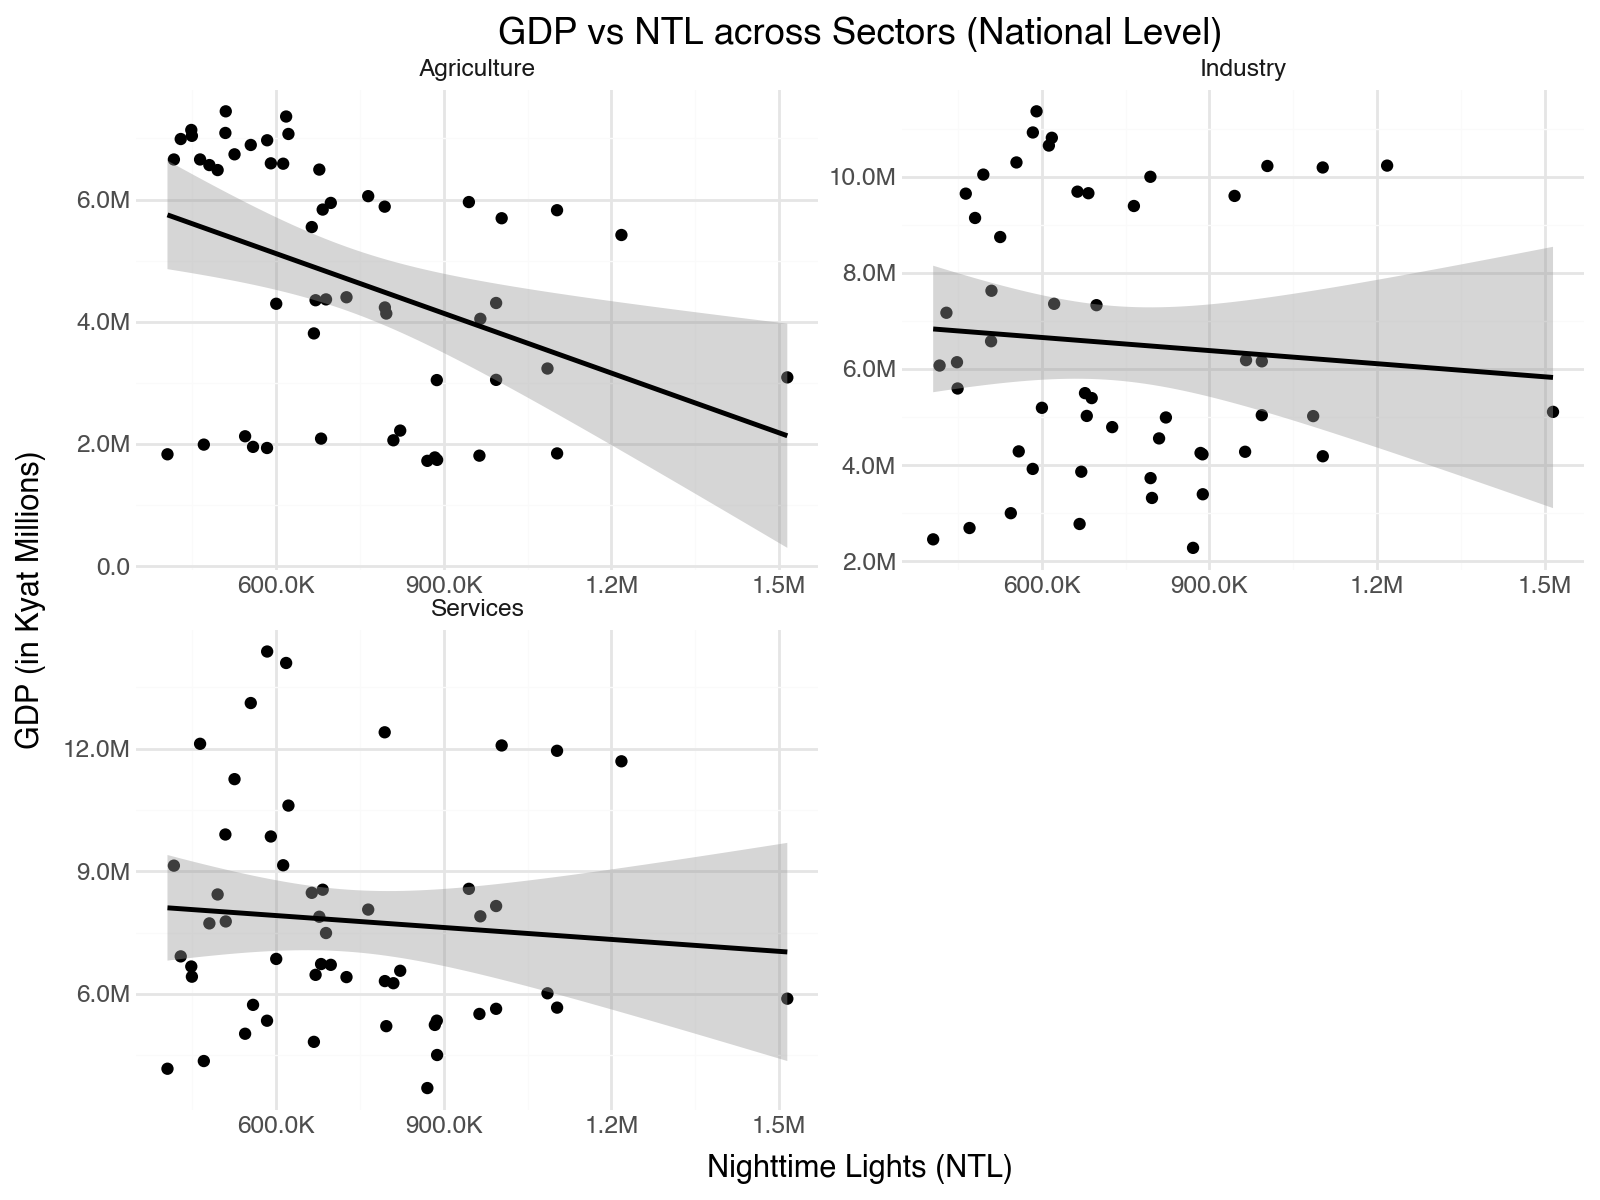

In [97]:
gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .groupby(["sub_group", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
)

(
    gdp_quarterly.join(ntl_adm0, how="inner").reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        x="Nighttime Lights (NTL)",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

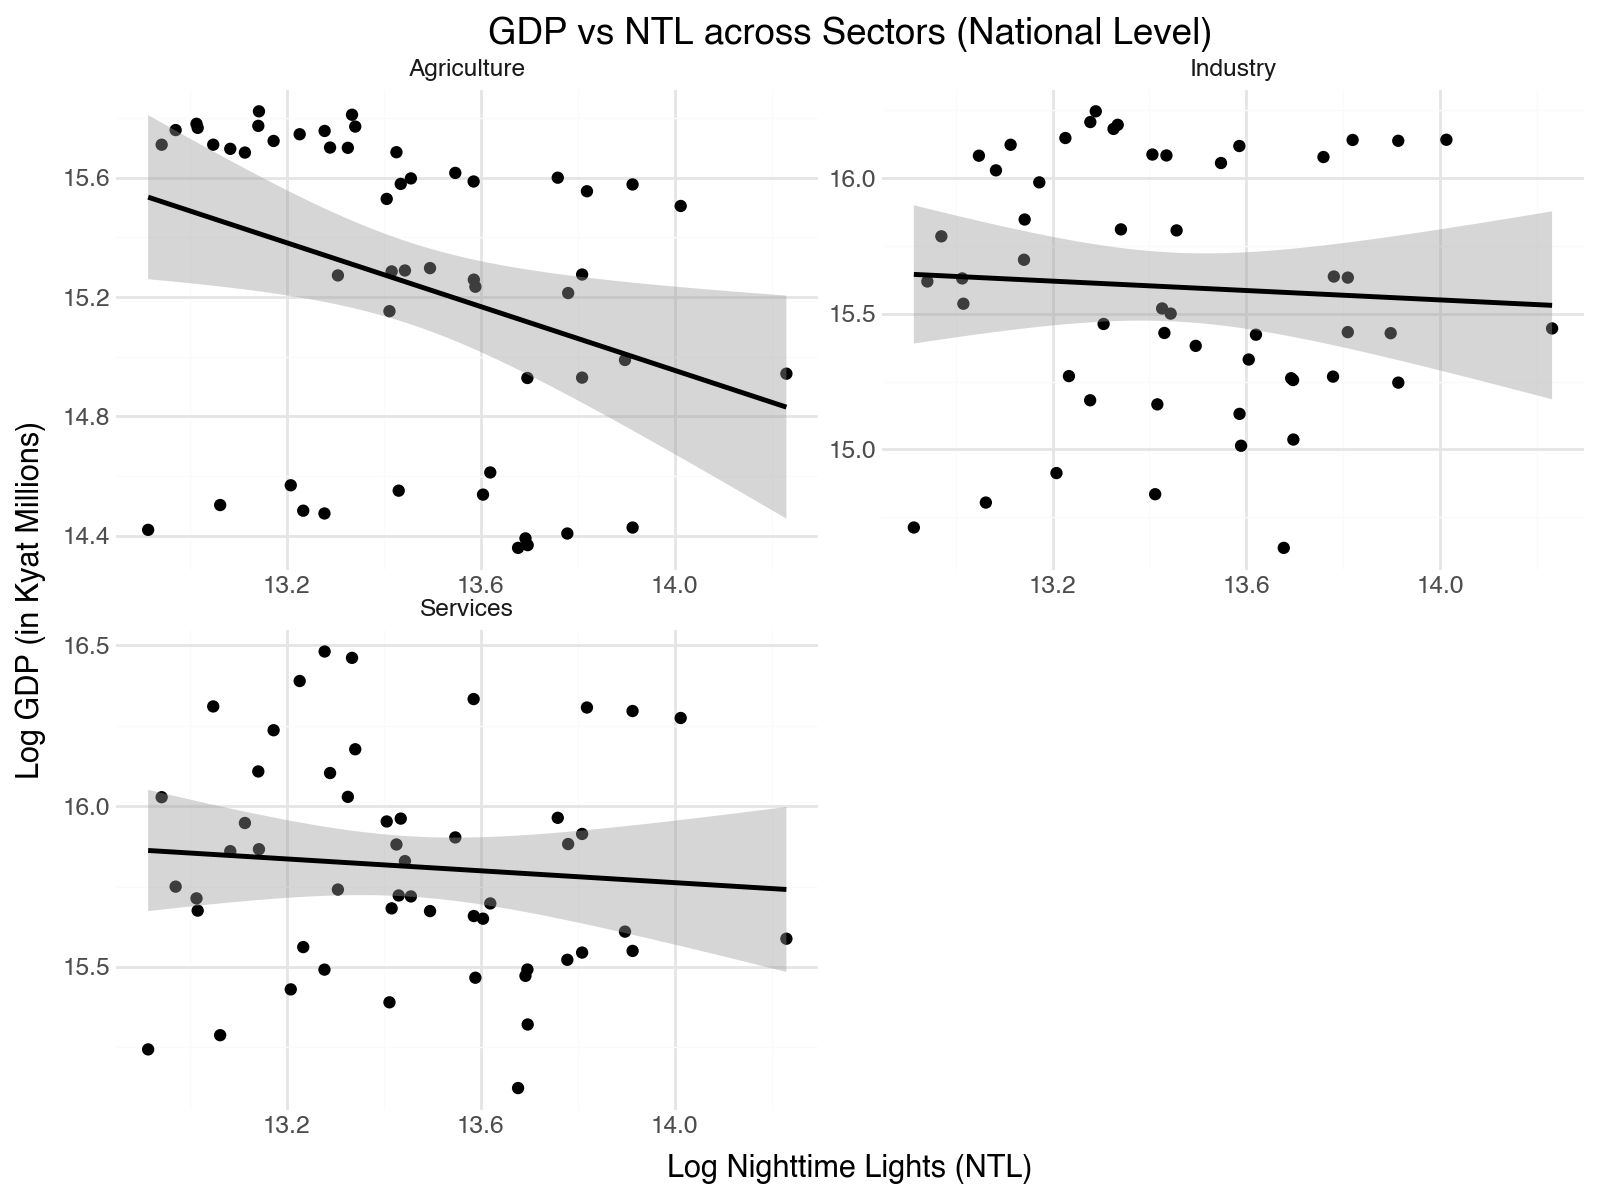

In [120]:
(
    gdp_quarterly.join(ntl_adm0, how="inner")
    .reset_index()
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_log=lambda df: np.log1p(df["gdp"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        x="Log Nighttime Lights (NTL)",
        y="Log GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

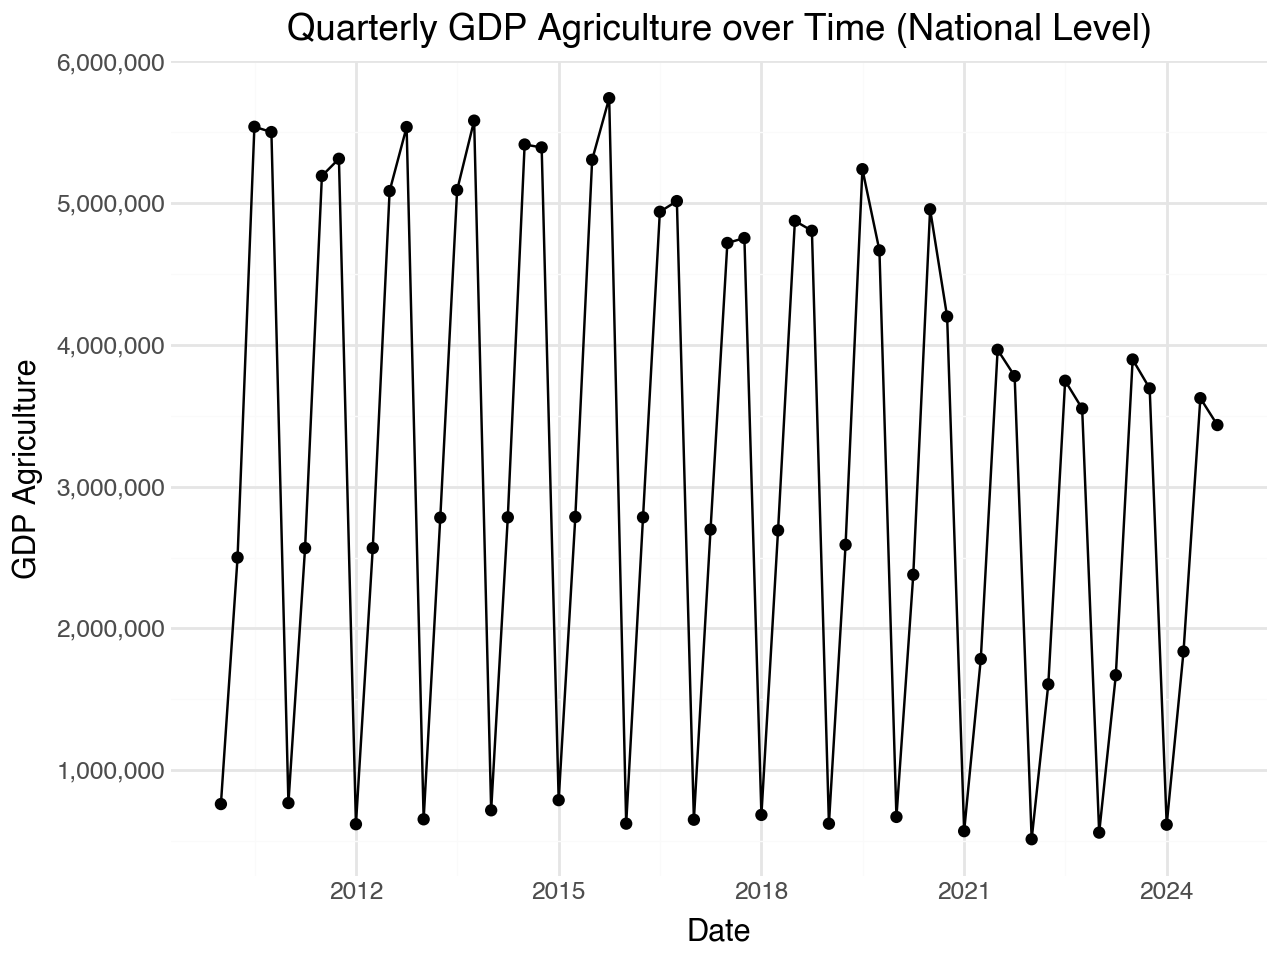

In [11]:
(
    gdp_agri_quarterly.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Quarterly GDP Agriculture over Time (National Level)",
        x="Date",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

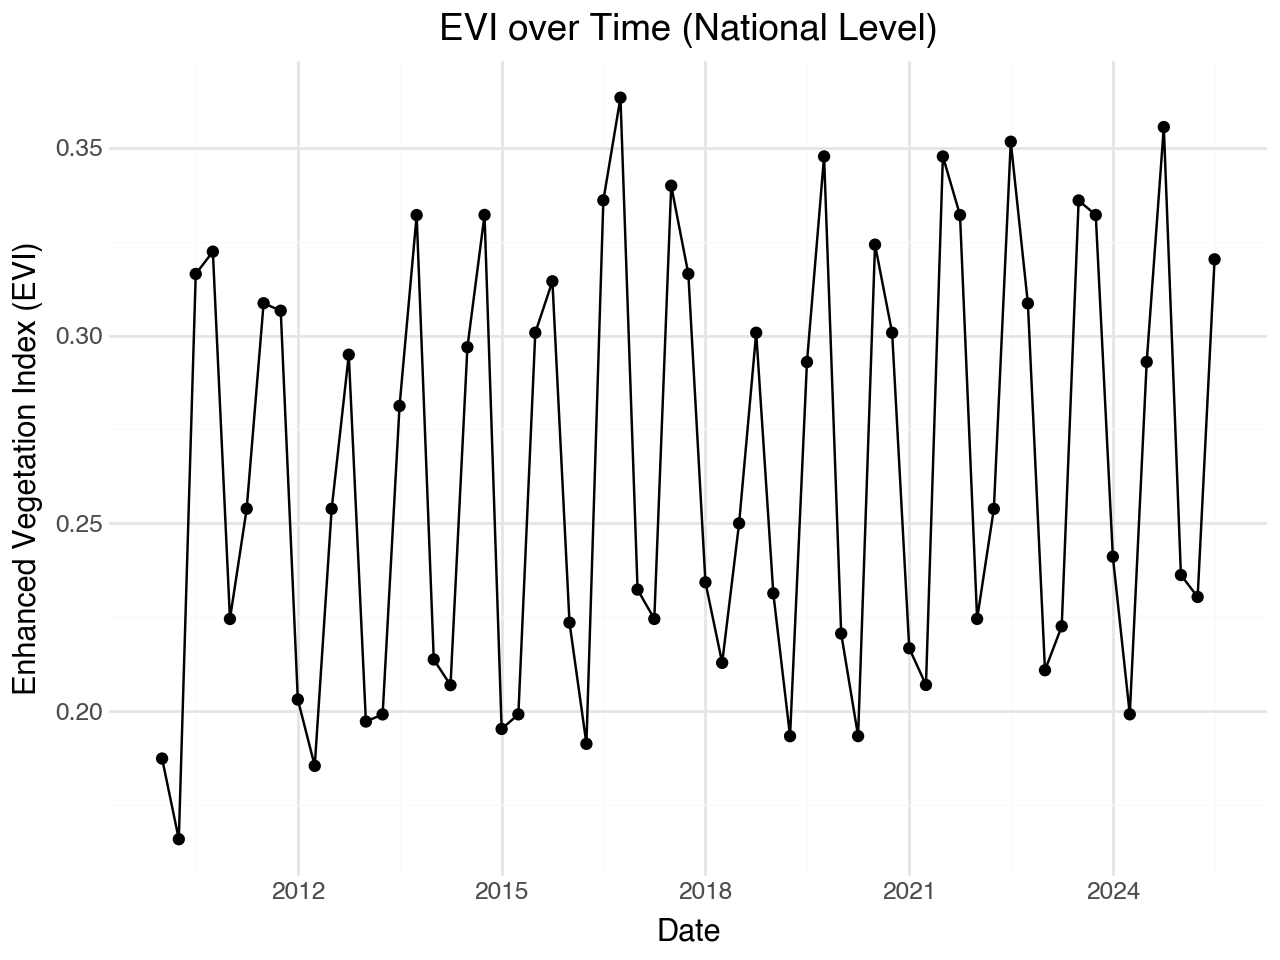

In [12]:
(
    evi_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_point()
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="EVI over Time (National Level)",
        x="Date",
        y="Enhanced Vegetation Index (EVI)",
    )
    + p9.theme_minimal()
)

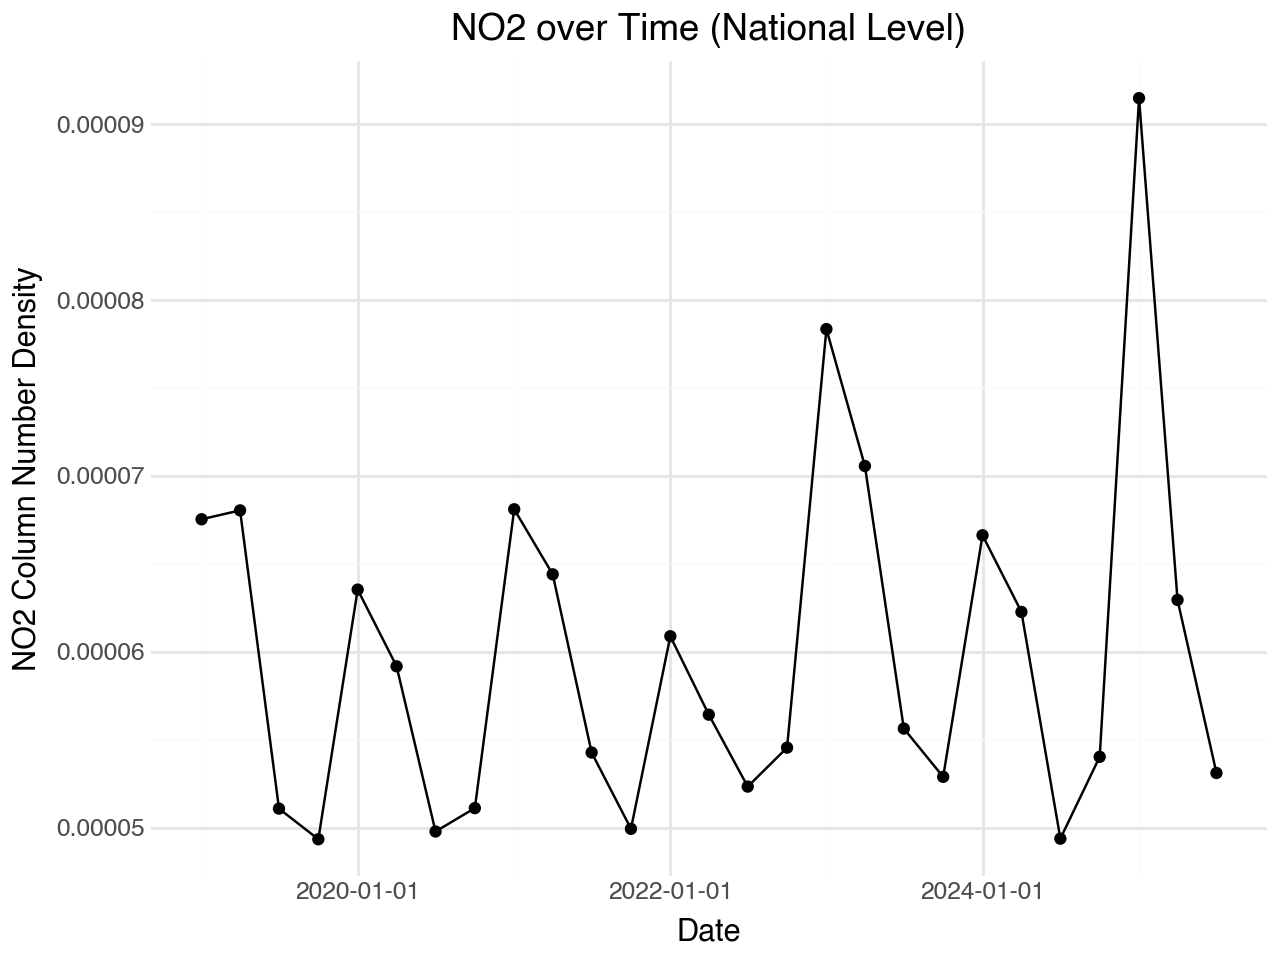

In [13]:
(
    no2_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="no2")
    + p9.geom_point()
    + p9.geom_line()
    # + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="NO2 over Time (National Level)",
        x="Date",
        y="NO2 Column Number Density",
    )
    + p9.theme_minimal()
)

### EVI

In [ ]:
evi_indicators = (
    gdp_agri_quarterly.join(evi_adm0, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        evi_lag_1=lambda df: df["evi"].shift(1),
        evi_lag_2=lambda df: df["evi"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        evi_lag_1_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_1"]]),
        evi_lag_2_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_2"]]),
    )
)
evi_indicators.tail()

,gdp_agri,evi,ntl_mean,ntl_sum,gdp_overall,evi_lag_1,evi_lag_2,ntl_mean_lag_1,evi_std,ntl_mean_std,ntl_sum_std,evi_lag_1_std,evi_lag_2_std
date,,,,,,,,,,,,,
2023-10-01,3.693112e+06,0.332062,0.094105,9.450224e+05,NaN,0.335932,0.222619,0.118108,1.185745,0.891204,0.931960,1.298006,-0.696805
2024-01-01,6.150236e+05,0.241148,0.082295,1.102821e+06,7.701545e+07,0.332062,0.335932,0.094105,-0.403751,0.384744,1.608715,1.229425,1.299359
2024-04-01,1.836623e+06,0.199210,0.114350,1.085608e+06,NaN,0.241148,0.332062,0.082295,-1.136981,1.759329,1.534892,-0.381889,1.231193
2024-07-01,3.624389e+06,0.292968,0.130503,1.217865e+06,NaN,0.199210,0.241148,0.114350,0.502245,2.452010,2.102106,-1.125184,-0.370387
2024-10-01,3.434594e+06,0.355467,0.066086,6.640315e+05,NaN,0.292968,0.199210,0.130503,1.594937,-0.310302,-0.273131,0.536542,-1.109191


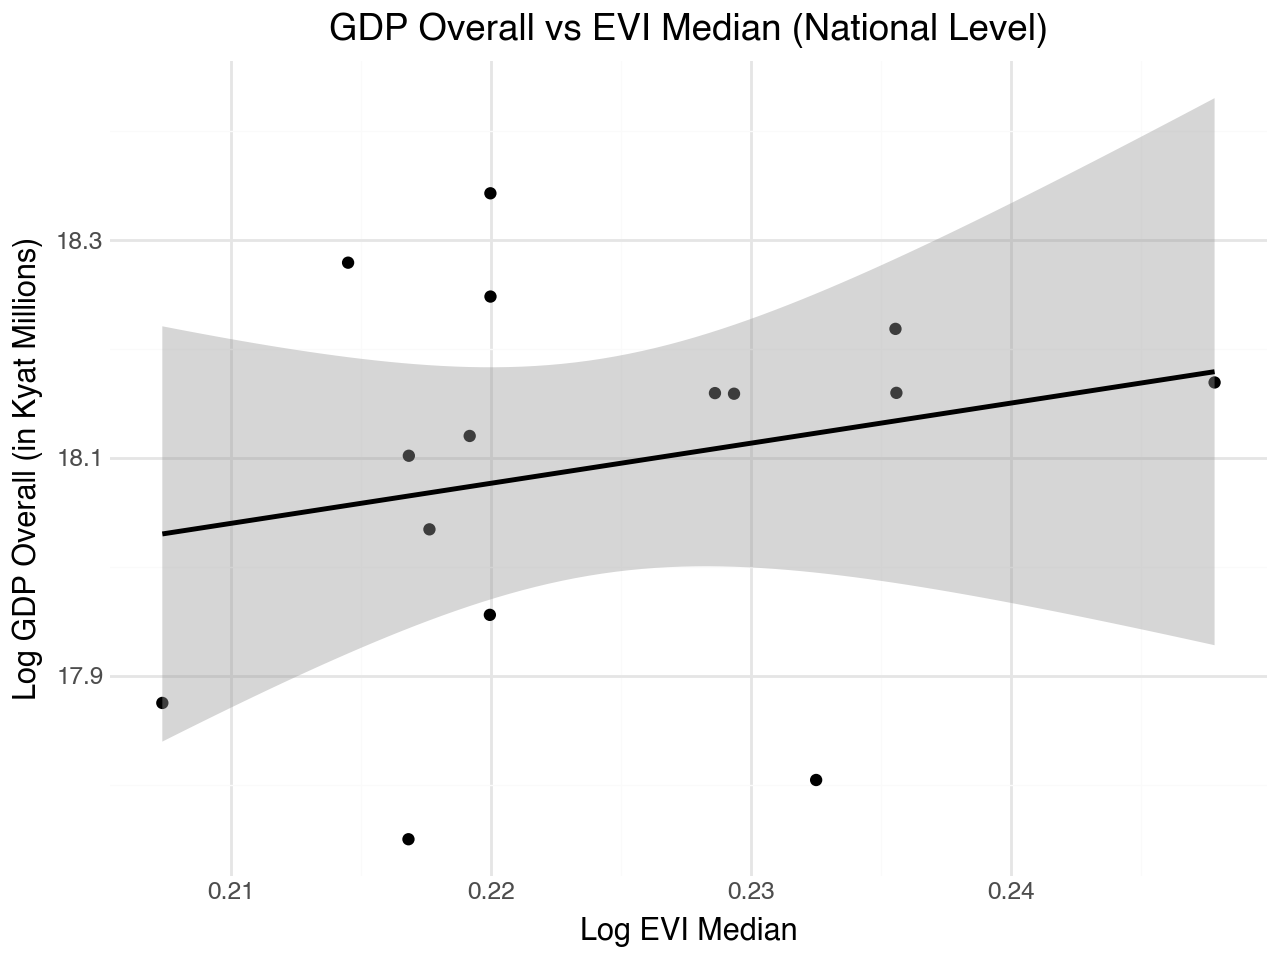

In [134]:
evi_adm0_annual = (
    evi_adm0_raw.groupby(pd.Grouper(freq="YS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    evi_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs EVI Median (National Level)",
        x="Log EVI Median",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

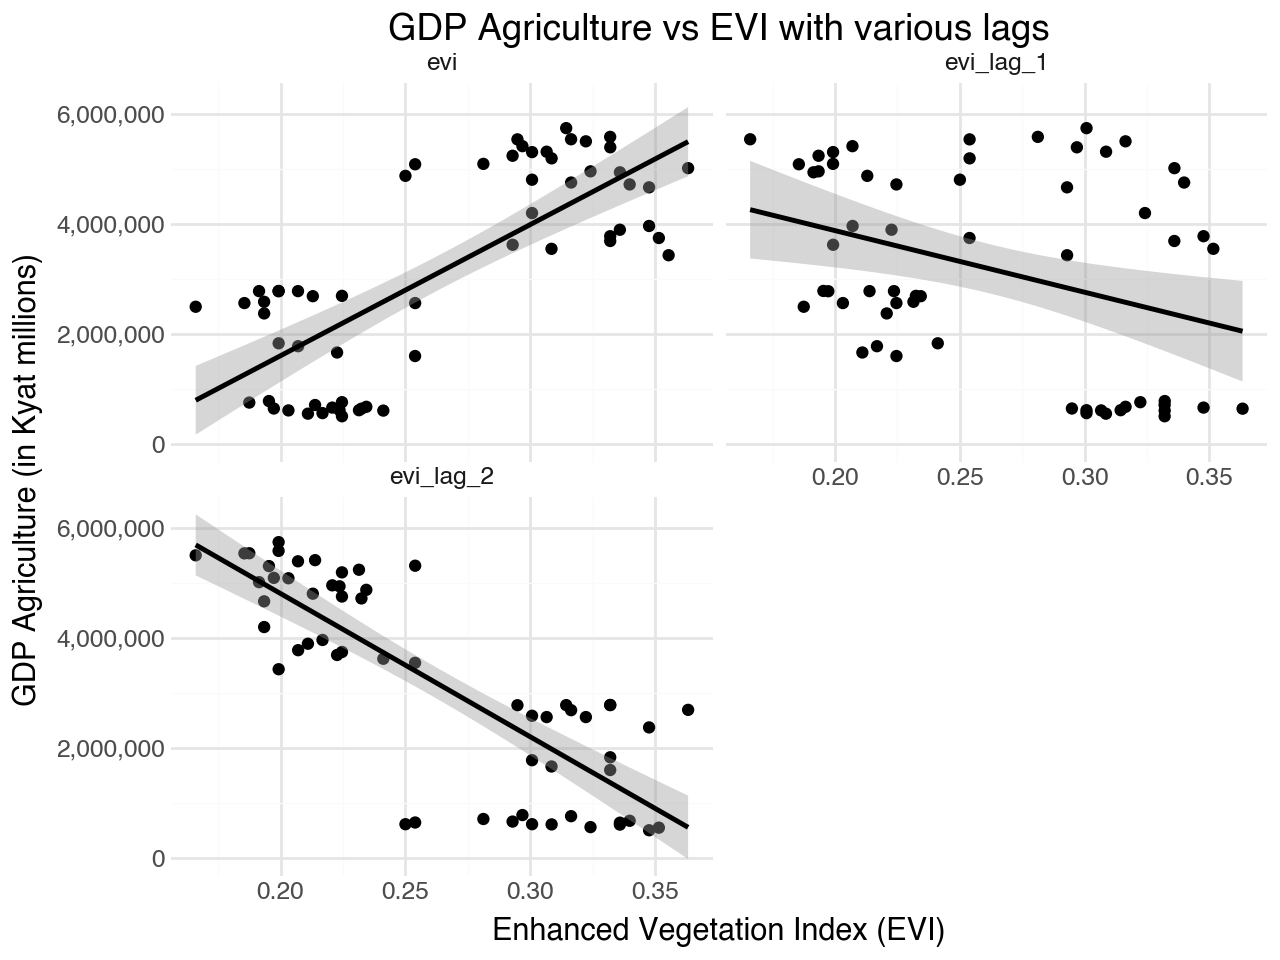

In [15]:
(
    evi_indicators.filter(["gdp_agri", "evi", "evi_lag_1", "evi_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_agri", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Agriculture vs EVI with various lags",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

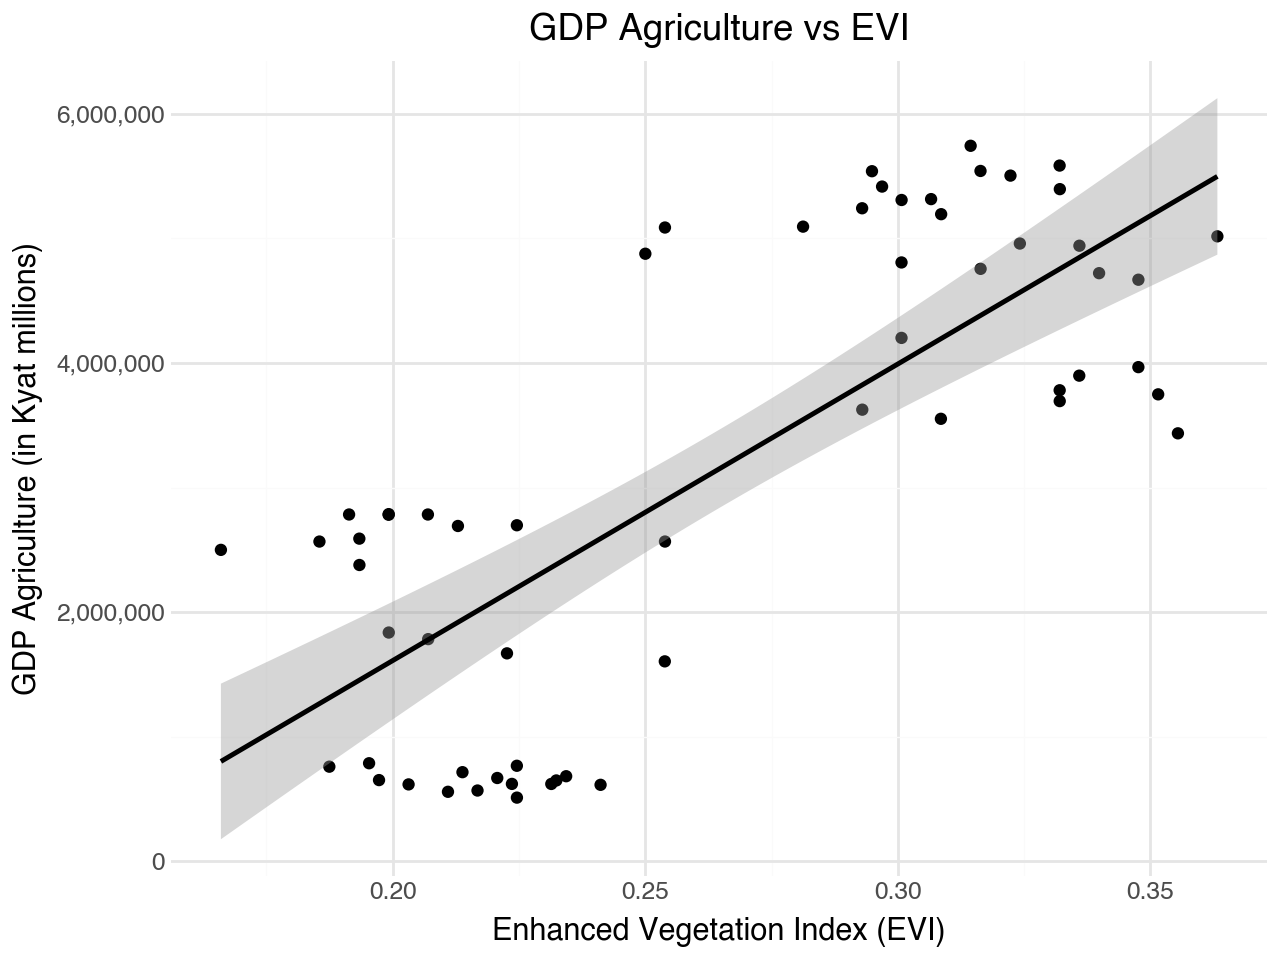

In [16]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


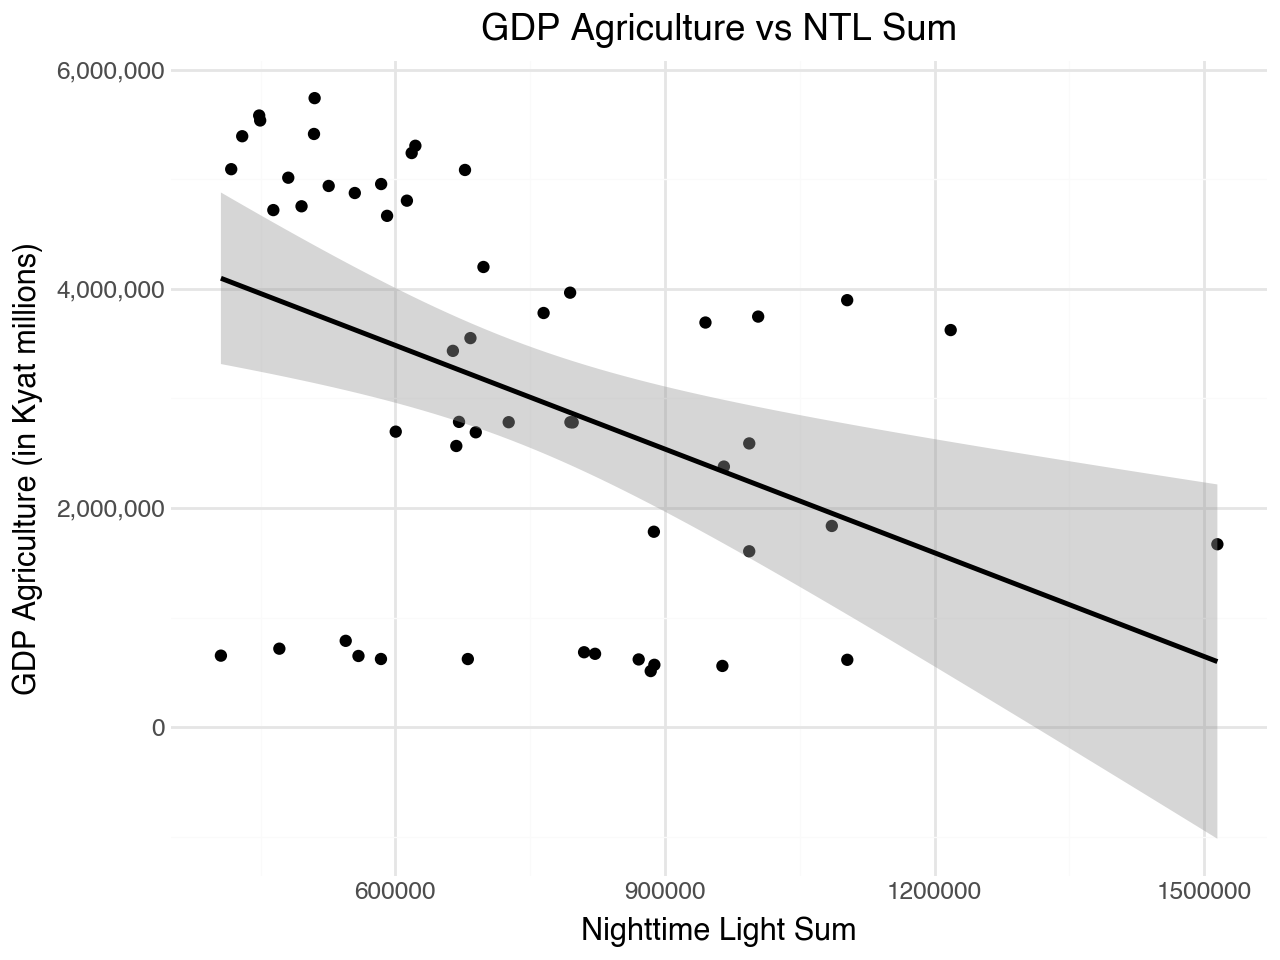

In [17]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

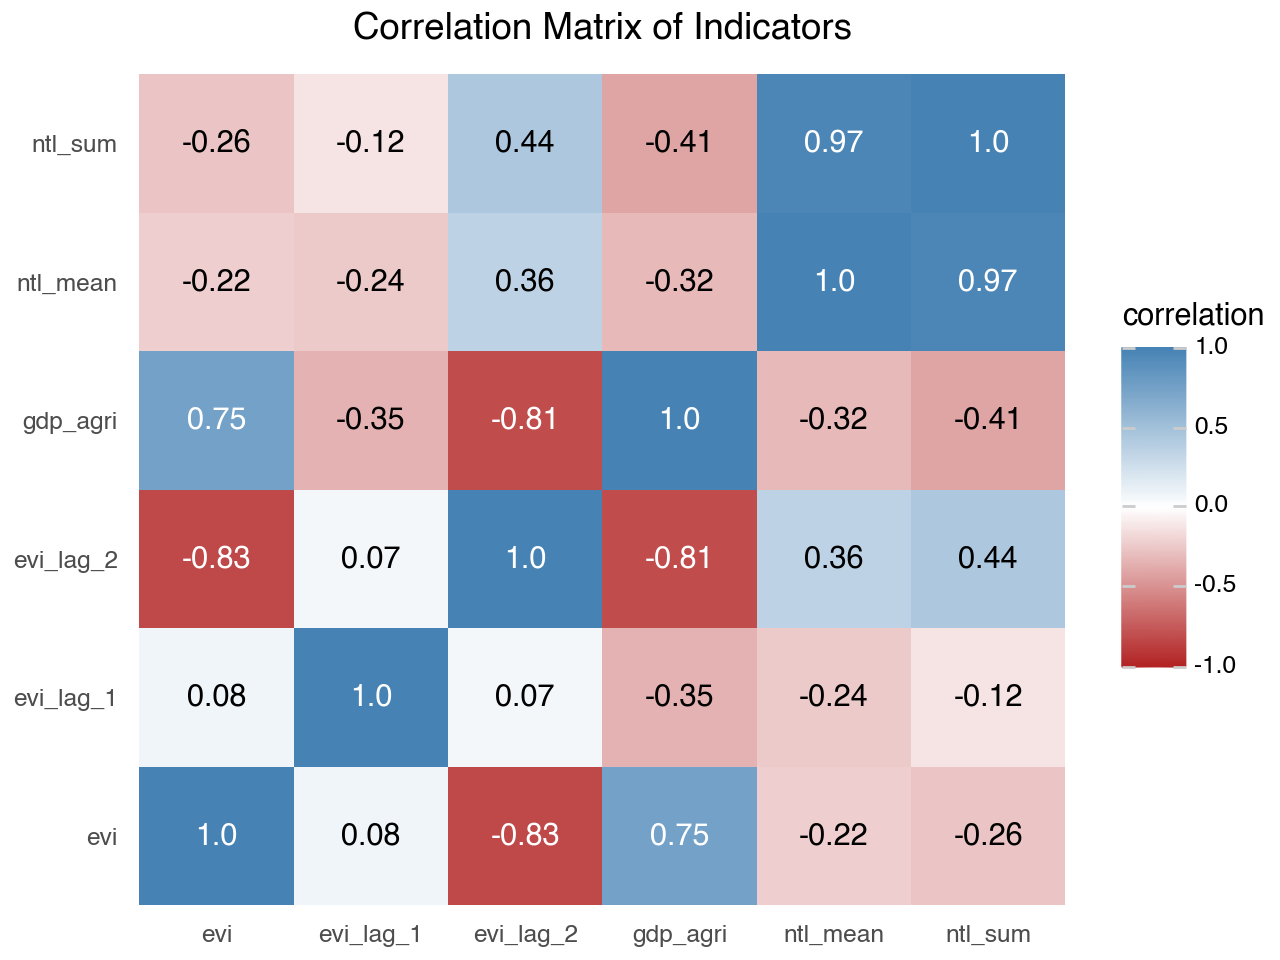

In [18]:
(
    evi_indicators.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [19]:
mod_1 = smf.ols("gdp_agri ~ evi", data=evi_indicators).fit()
mod_2 = smf.ols("gdp_agri ~ ntl_sum + evi", data=evi_indicators).fit()
mod_3 = smf.ols(
    "gdp_agri ~ ntl_sum + evi + evi_lag_1 + evi_lag_2", data=evi_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [20]:
mod_4 = smf.ols(
    "gdp_agri ~ ntl_mean_std + evi_std + evi_lag_1_std + evi_lag_2_std",
    data=evi_indicators,
).fit()

Stargazer([mod_4])

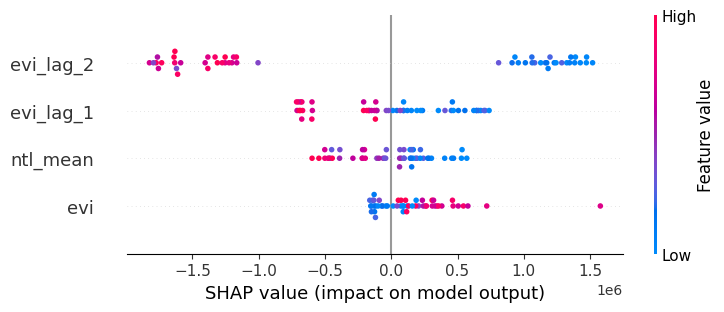

In [21]:
evi_indicators_clean = evi_indicators.dropna()
X = evi_indicators_clean[["evi", "ntl_mean", "evi_lag_1", "evi_lag_2"]]
y = evi_indicators_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### NO2

In [22]:
no2_indicators = (
    gdp_mft_quarterly.join(no2_adm0, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
)
no2_indicators.tail()

,gdp_mft,no2,ntl_mean,ntl_sum,no2_lag_1,no2_lag_2,ntl_mean_lag_1,no2_std,ntl_mean_std,ntl_sum_std,no2_lag_1_std,no2_lag_2_std
date,,,,,,,,,,,,
2023-10-01,9.600970e+06,0.000053,0.094105,9.450224e+05,0.000056,0.000071,0.118108,-0.739904,0.891204,0.931960,-0.414237,1.403455
2024-01-01,4.181992e+06,0.000067,0.082295,1.102821e+06,0.000053,0.000056,0.094105,0.991350,0.384744,1.608715,-0.755570,-0.473710
2024-04-01,5.017848e+06,0.000062,0.114350,1.085608e+06,0.000067,0.000053,0.082295,0.441926,1.759329,1.534892,0.952487,-0.818883
2024-07-01,1.023193e+07,0.000049,0.130503,1.217865e+06,0.000062,0.000067,0.114350,-1.182759,2.452010,2.102106,0.410425,0.908387
2024-10-01,9.689597e+06,0.000054,0.066086,6.640315e+05,0.000049,0.000062,0.130503,-0.596329,-0.310302,-0.273131,-1.192493,0.360228


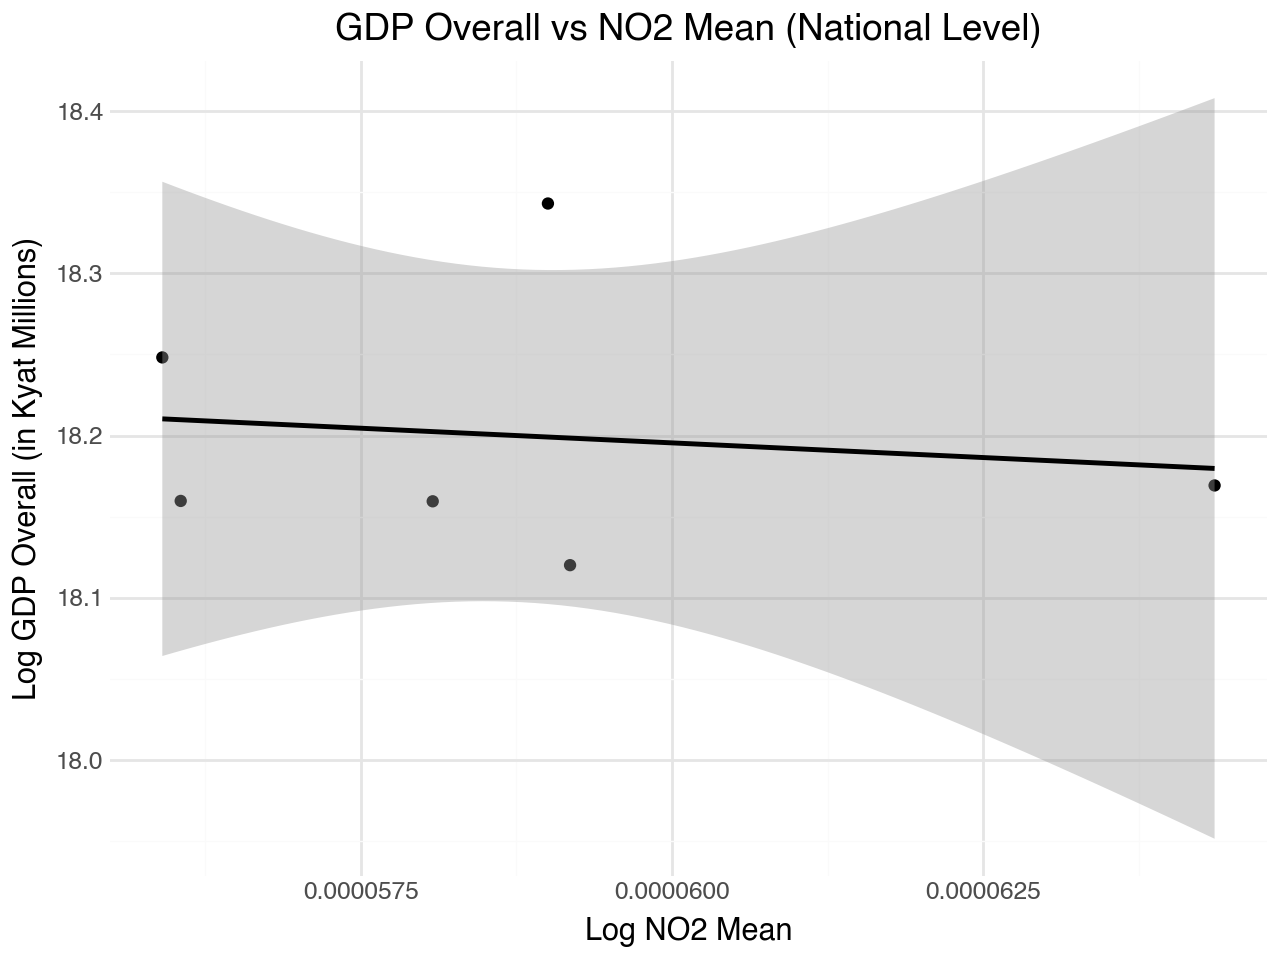

In [136]:
no2_adm0_annual = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="YS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

(
    no2_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NO2 Mean (National Level)",
        x="Log NO2 Mean",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

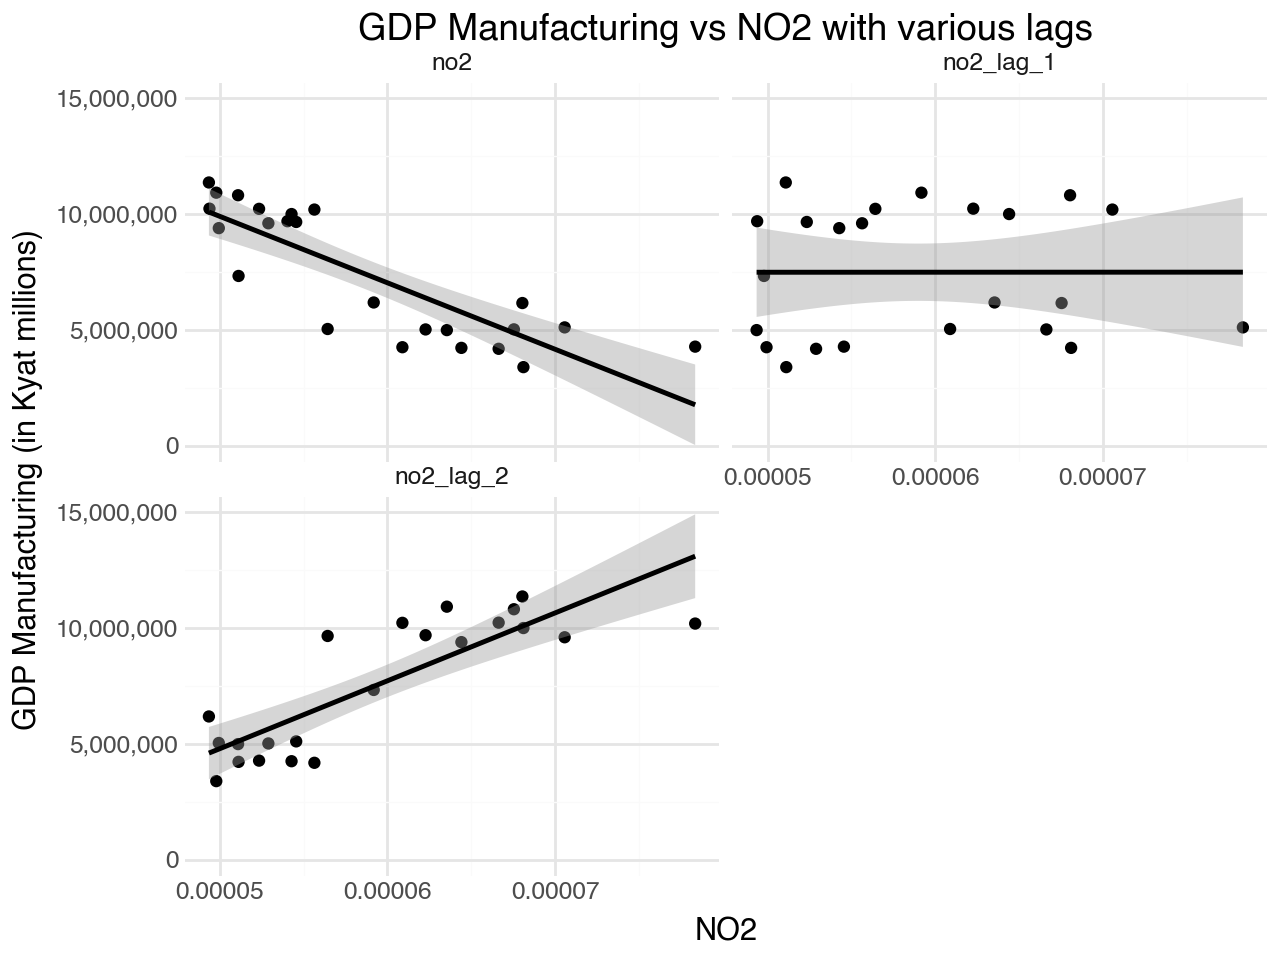

In [23]:
(
    no2_indicators.filter(["gdp_mft", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_mft", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Manufacturing vs NO2 with various lags",
        x="NO2",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


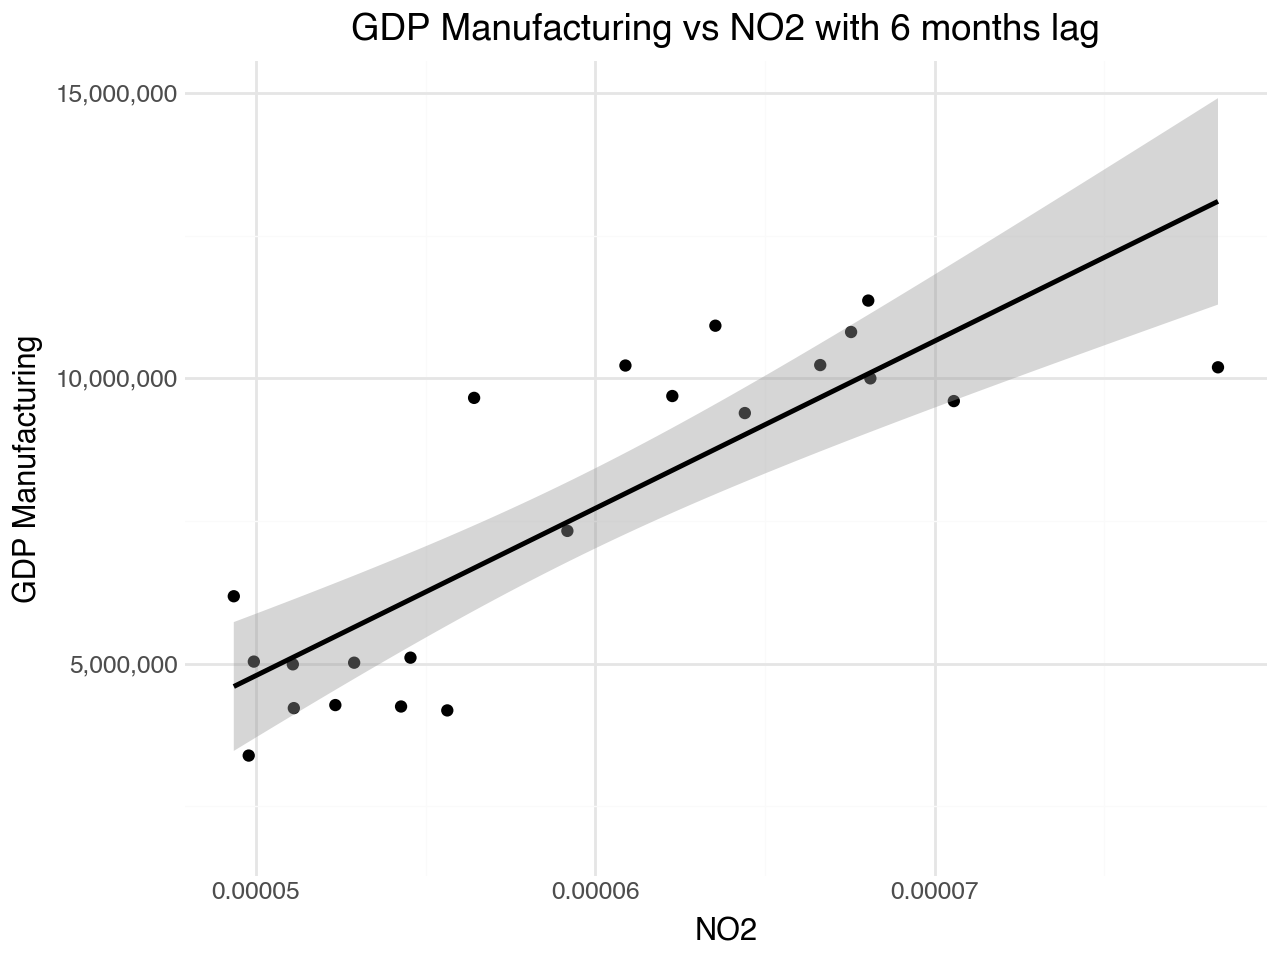

In [24]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_lag_2", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2 with 6 months lag",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


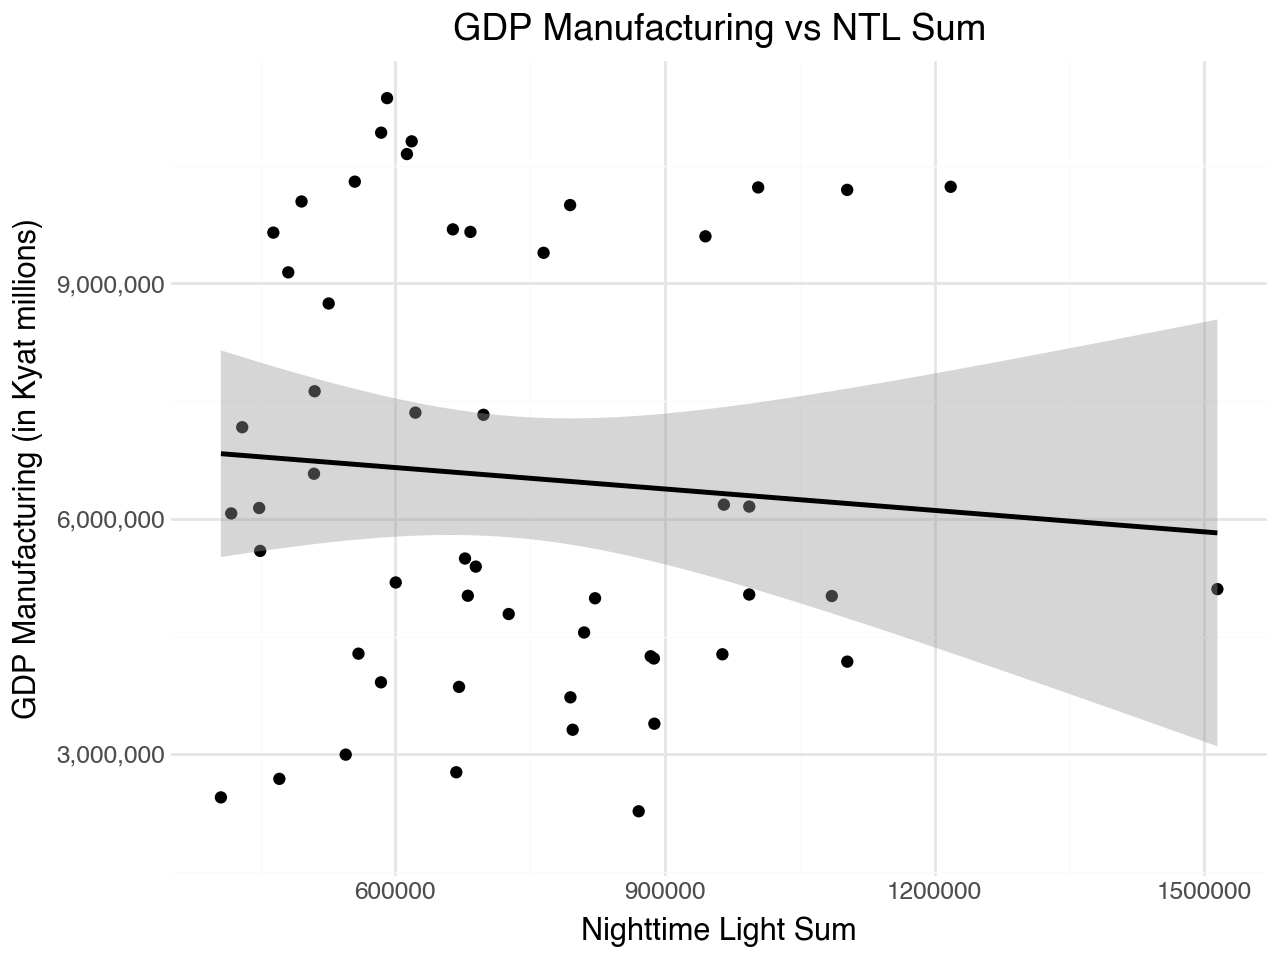

In [25]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.theme_minimal()
)

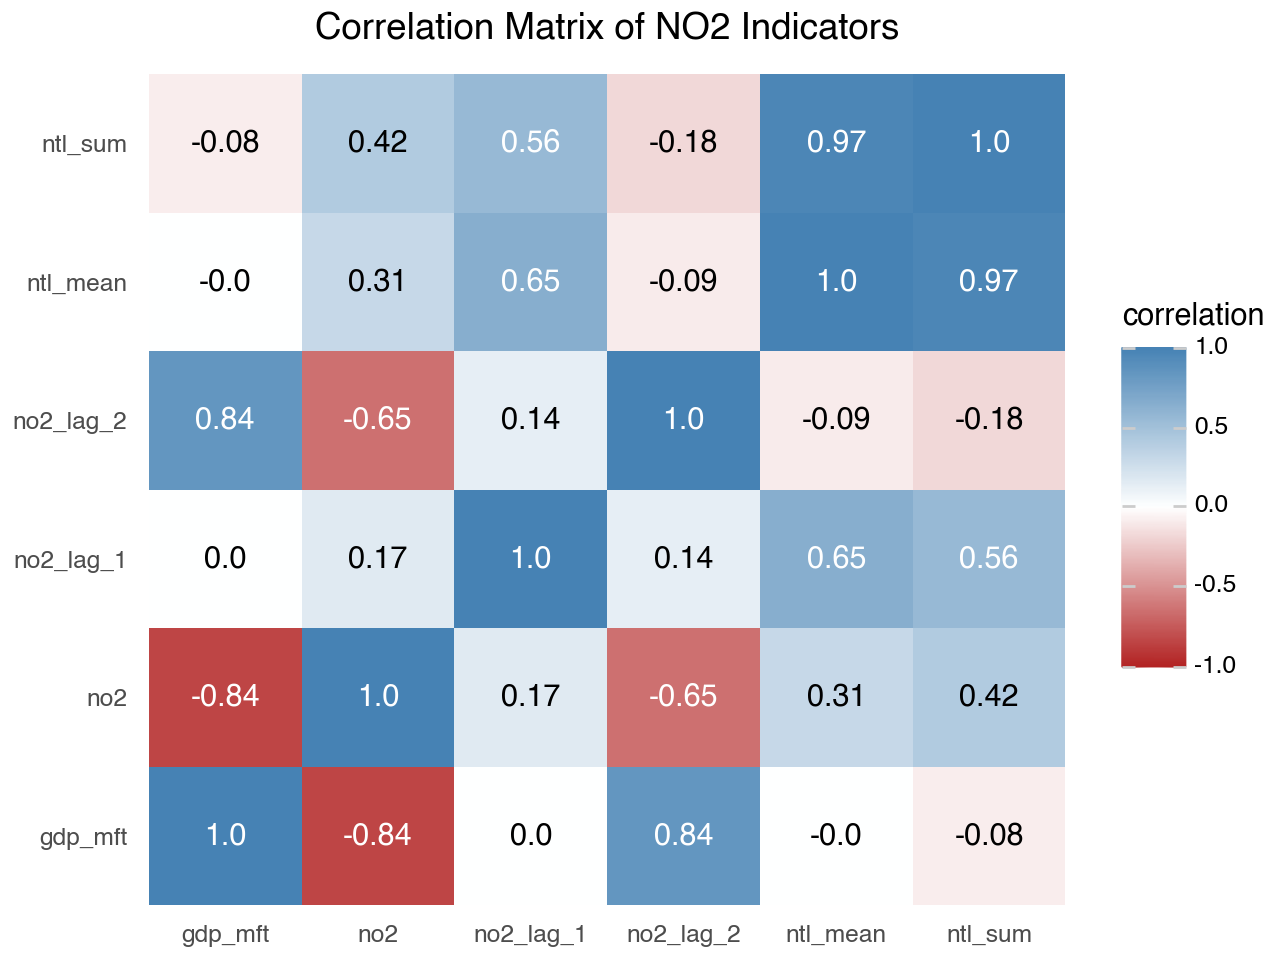

In [26]:
(
    no2_indicators.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of NO2 Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [27]:
mod_1 = smf.ols("gdp_mft ~ no2", data=no2_indicators).fit()
mod_2 = smf.ols("gdp_mft ~ ntl_mean + no2", data=no2_indicators).fit()
mod_3 = smf.ols(
    "gdp_mft ~ ntl_mean + no2 + no2_lag_1 + no2_lag_2", data=no2_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [28]:
mod_4 = smf.ols(
    "gdp_mft ~ ntl_mean_std + no2_std + no2_lag_1_std + no2_lag_2_std",
    data=no2_indicators,
).fit()

Stargazer([mod_4])

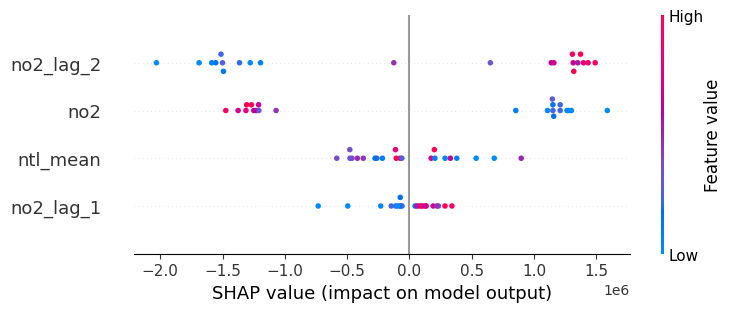

In [29]:
no2_indicators_clean = no2_indicators.dropna()
X = no2_indicators_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

## Admin Level 1 Analysis

### EVI

In [30]:
evi_indicators_adm1 = (
    gdp_agri_quarterly_adm1.join(evi_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_agri_c=lambda df: df["gdp_agri"] - df["gdp_agri"].mean(),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            evi_lag_1=df["evi"].shift(1),
            evi_lag_2=df["evi"].shift(2),
            evi_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_1"]]
            ),
            evi_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_2"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

evi_indicators_adm1.tail()

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/2438215213.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


gdp_agri       evi  ntl_mean        ntl_sum  \
adm1_name date                                                           
Yangon    2023-10-01  181051.782036  0.271540  1.341484  193872.643026   
          2024-01-01   30151.025456  0.252937  1.288833  248295.662349   
          2024-04-01   90038.926517  0.169862  1.451145  178197.192109   
          2024-07-01  177682.711182  0.285272  1.254324  155936.478288   
          2024-10-01  168378.157293  0.298772  1.215892  175752.381717   

                         gdp_agri_c   evi_std  ntl_mean_std  ntl_sum_std  \
adm1_name date                                                             
Yangon    2023-10-01    6613.860622 -0.310754      4.226818     3.852709   
          2024-01-01 -144286.895958 -0.535517      4.039194     5.219149   
          2024-04-01  -84398.994896 -1.539252      4.617595     3.459133   
          2024-07-01    3244.789768 -0.144840      3.916221     2.900216   
          2024-10-01   -6059.764121  0.018271      3.779268     3.397749   

                      evi_lag_1  evi_lag_2  evi_lag_1_std  evi_lag_2_std  \
adm1_name date                                                             
Yangon    2023-10-01   0.308539   0.169897       0.398672      -1.335612   
          2024-01-01   0.271540   0.308539      -0.067667       0.397119   
          2024-04-01   0.252937   0.271540      -0.302135      -0.065296   
          2024-07-01   0.169862   0.252937      -1.349206      -0.297790   
          2024-10-01   0.285272   0.169862       0.105410      -1.336050   

                      ntl_mean_lag_1  
adm1_name date                        
Yangon    2023-10-01        1.371373  
          2024-01-01        1.341484  
          2024-04-01        1.288833  
          2024-07-01        1.451145  
          2024-10-01        1.254324

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 24 rows containing missing values.


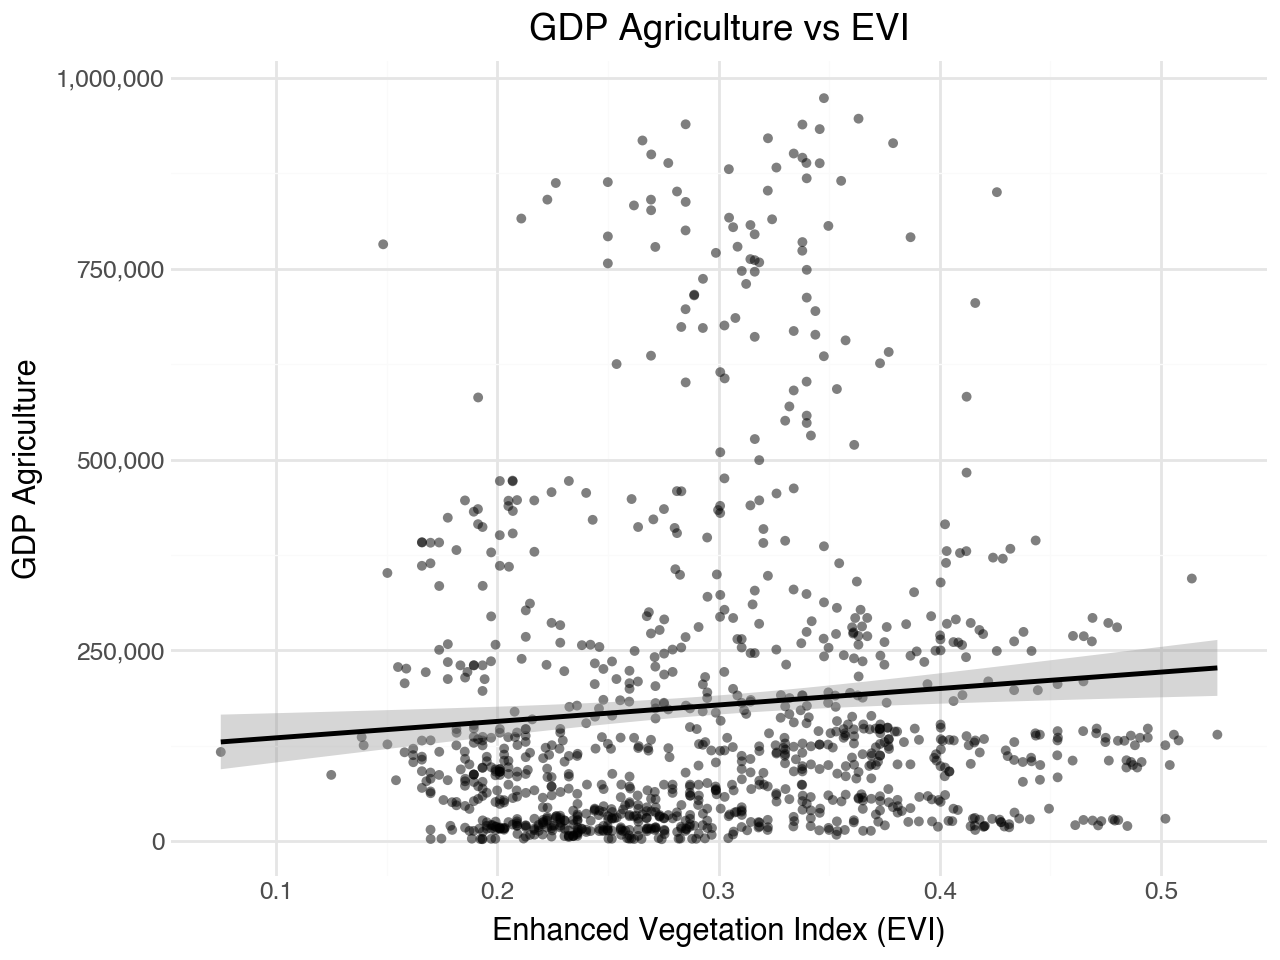

In [31]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 144 rows containing missing values.


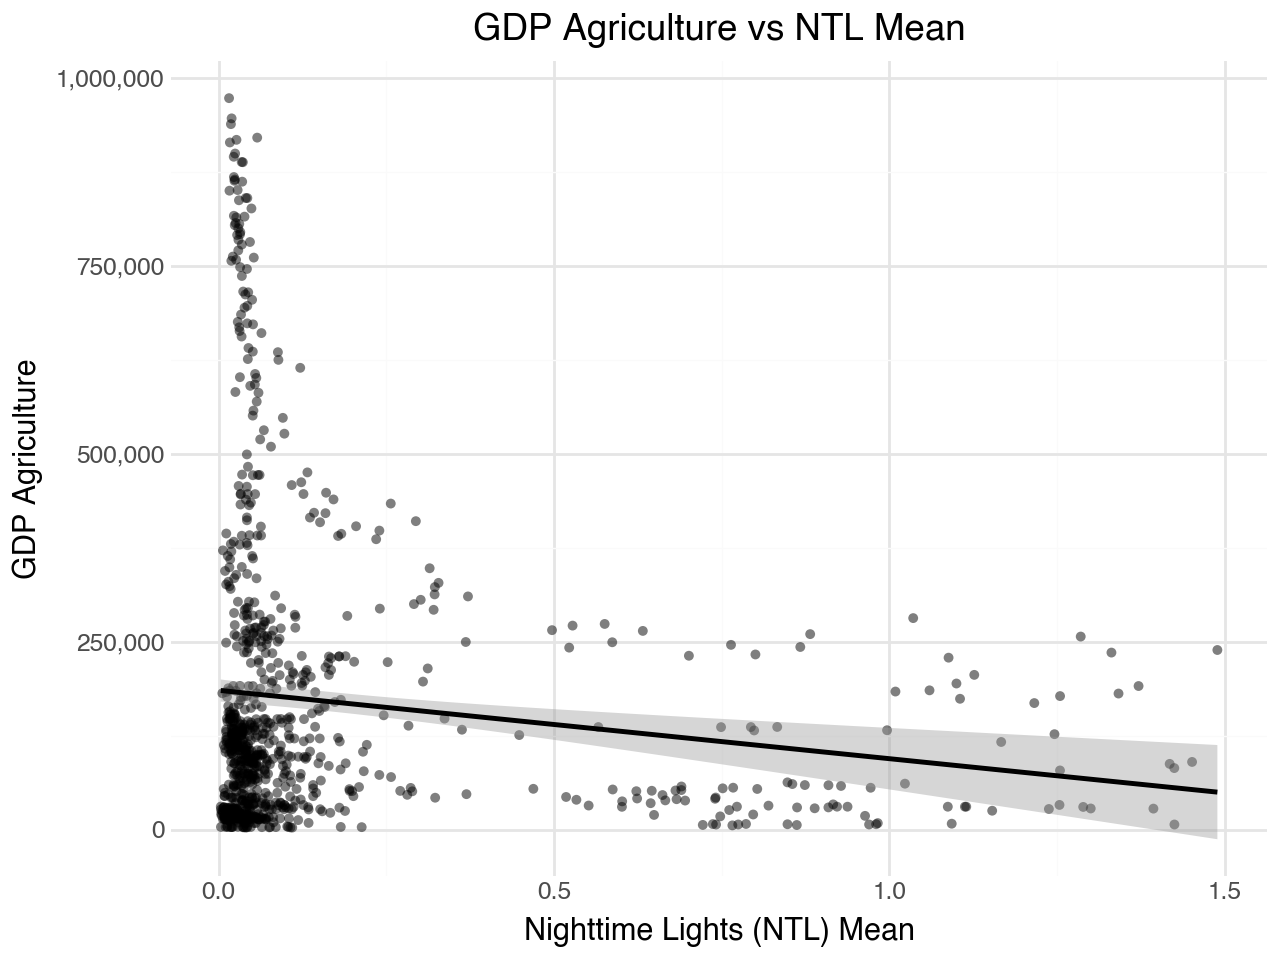

In [32]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

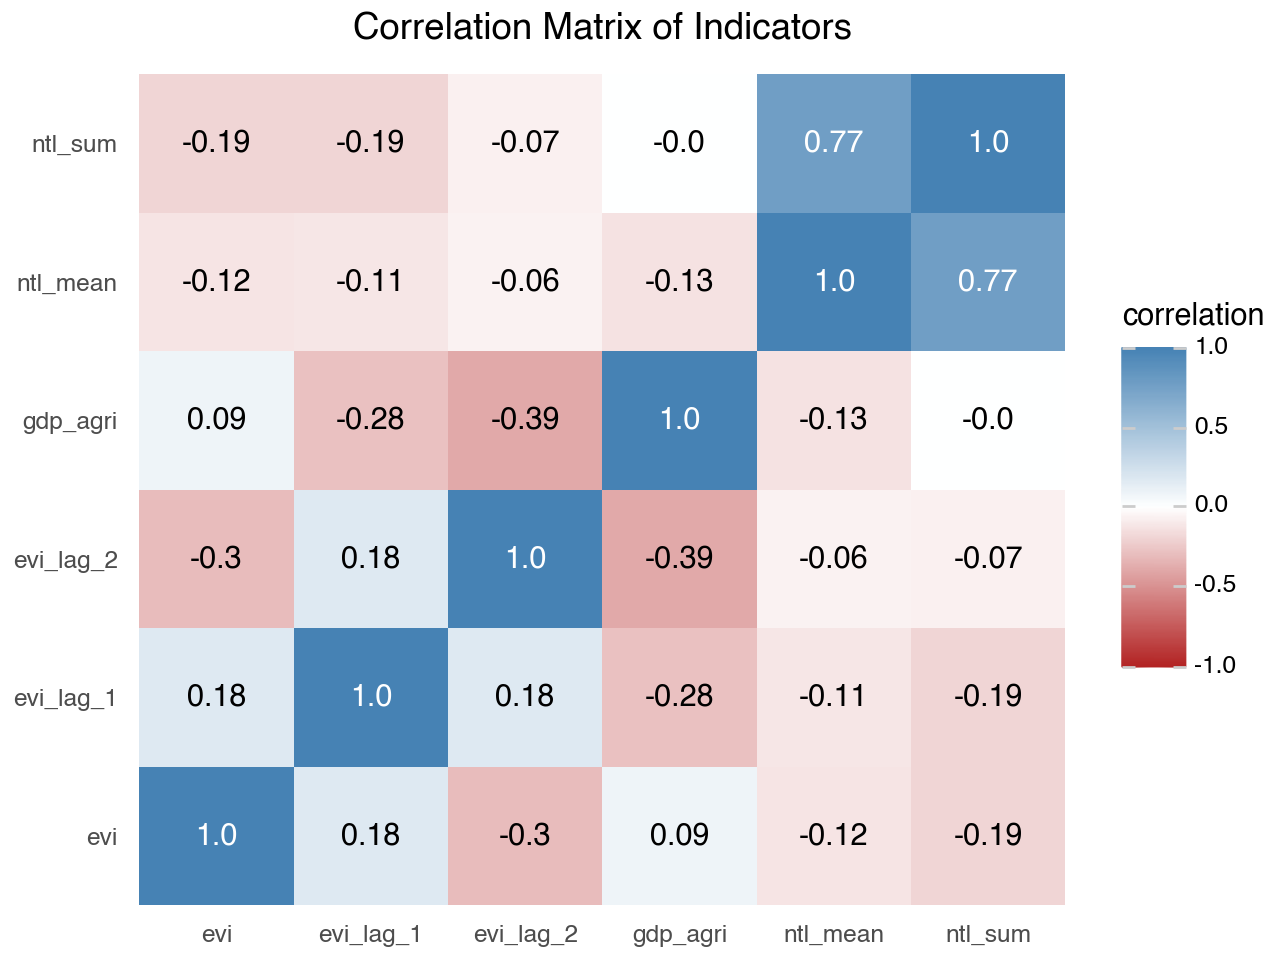

In [33]:
(
    evi_indicators_adm1.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

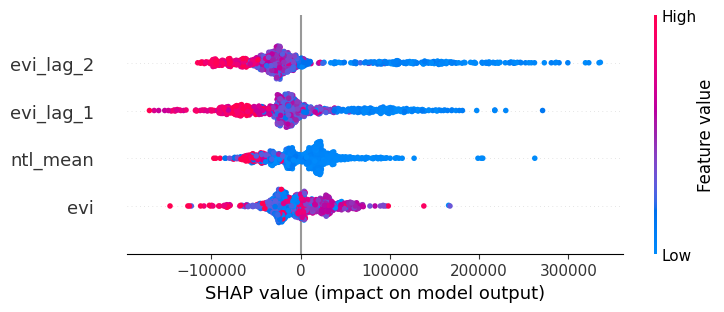

In [34]:
evi_indicators_adm_1_clean = evi_indicators_adm1.dropna()
X = evi_indicators_adm_1_clean[["evi", "ntl_mean", "evi_lag_1", "evi_lag_2"]]
y = evi_indicators_adm_1_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### NO2

In [35]:
no2_indicators_adm1 = (
    gdp_mft_quarterly_adm1.join(no2_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_mft_c=lambda df: df["gdp_mft"] - df["gdp_mft"].mean(),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            no2_lag_1=df["no2"].shift(1),
            no2_lag_2=df["no2"].shift(2),
            no2_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_1"]]
            ),
            no2_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_2"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

no2_indicators_adm1.tail()

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_91607/2440866222.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


gdp_mft       no2  ntl_mean        ntl_sum  \
adm1_name date                                                          
Yangon    2023-10-01  3.398282e+06  0.000084  1.341484  193872.643026   
          2024-01-01  1.480224e+06  0.000117  1.288833  248295.662349   
          2024-04-01  1.776077e+06  0.000078  1.451145  178197.192109   
          2024-07-01  3.621611e+06  0.000053  1.254324  155936.478288   
          2024-10-01  3.429651e+06  0.000083  1.215892  175752.381717   

                         gdp_mft_c   no2_std  ntl_mean_std  ntl_sum_std  \
adm1_name date                                                            
Yangon    2023-10-01  3.057078e+06  2.632758      4.226818     3.852709   
          2024-01-01  1.139020e+06  5.776550      4.039194     5.219149   
          2024-04-01  1.434873e+06  2.078155      4.617595     3.459133   
          2024-07-01  3.280407e+06 -0.345225      3.916221     2.900216   
          2024-10-01  3.088447e+06  2.531909      3.779268     3.397749   

                      no2_lag_1  no2_lag_2  no2_lag_1_std  no2_lag_2_std  \
adm1_name date                                                             
Yangon    2023-10-01   0.000061   0.000082      -0.842427       0.240989   
          2024-01-01   0.000084   0.000061       0.380219      -0.915259   
          2024-04-01   0.000117   0.000084       2.129763       0.327460   
          2024-07-01   0.000078   0.000117       0.071578       2.105729   
          2024-10-01   0.000053   0.000078      -1.277053       0.013752   

                      ntl_mean_lag_1  
adm1_name date                        
Yangon    2023-10-01        1.371373  
          2024-01-01        1.341484  
          2024-04-01        1.288833  
          2024-07-01        1.451145  
          2024-10-01        1.254324

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 648 rows containing missing values.


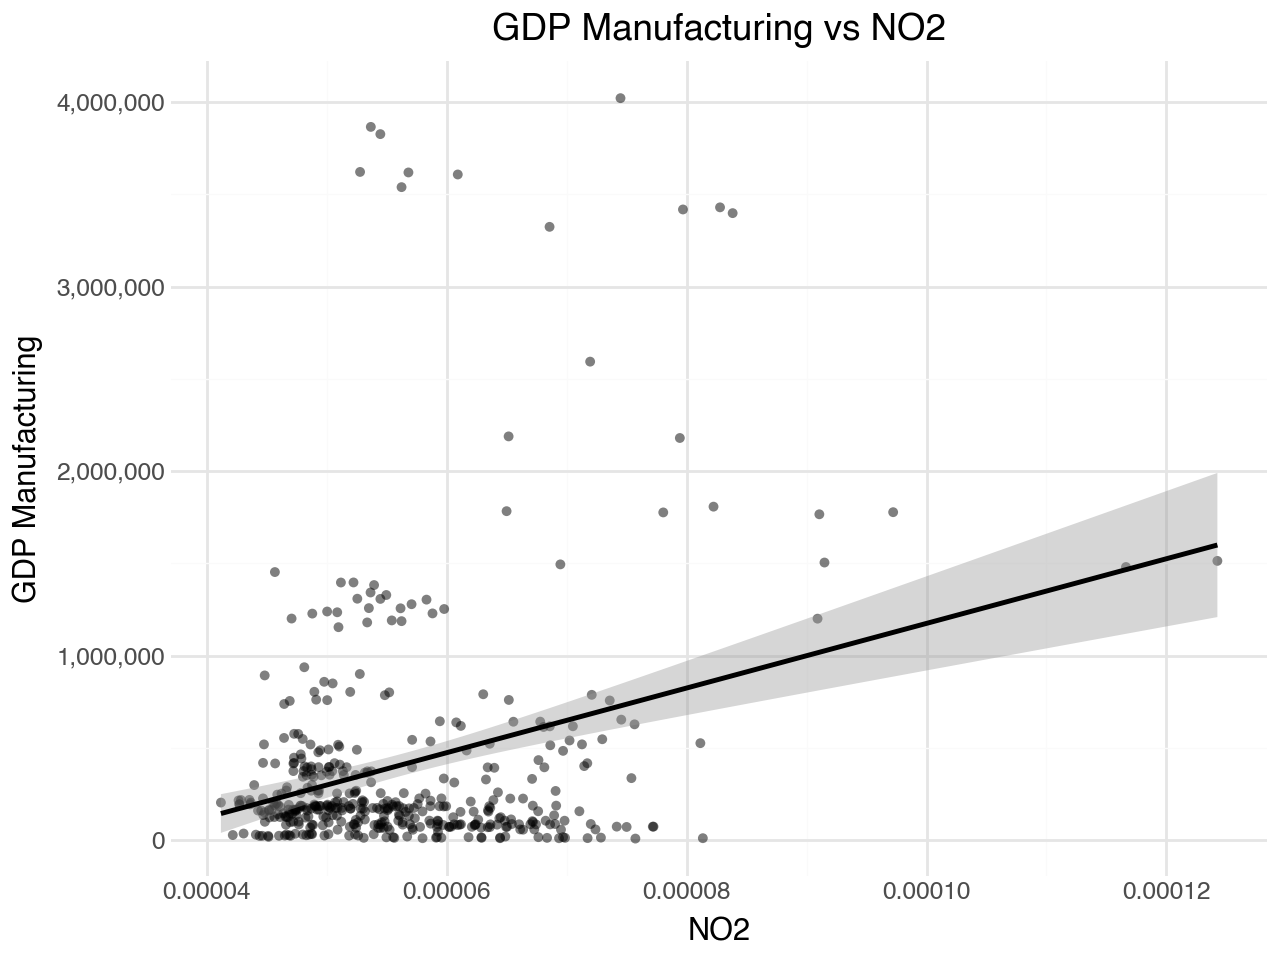

In [36]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 144 rows containing missing values.


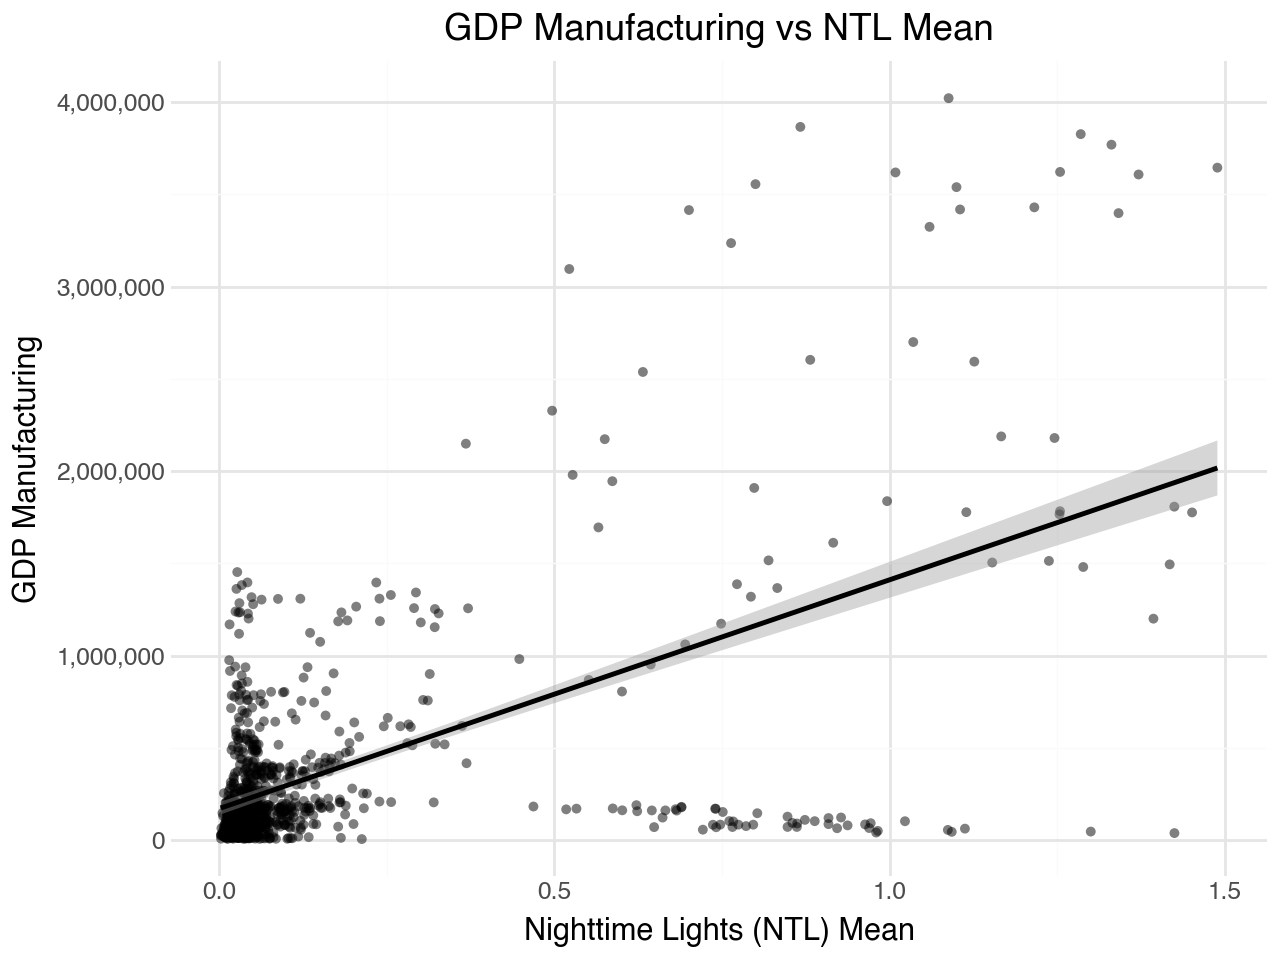

In [37]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

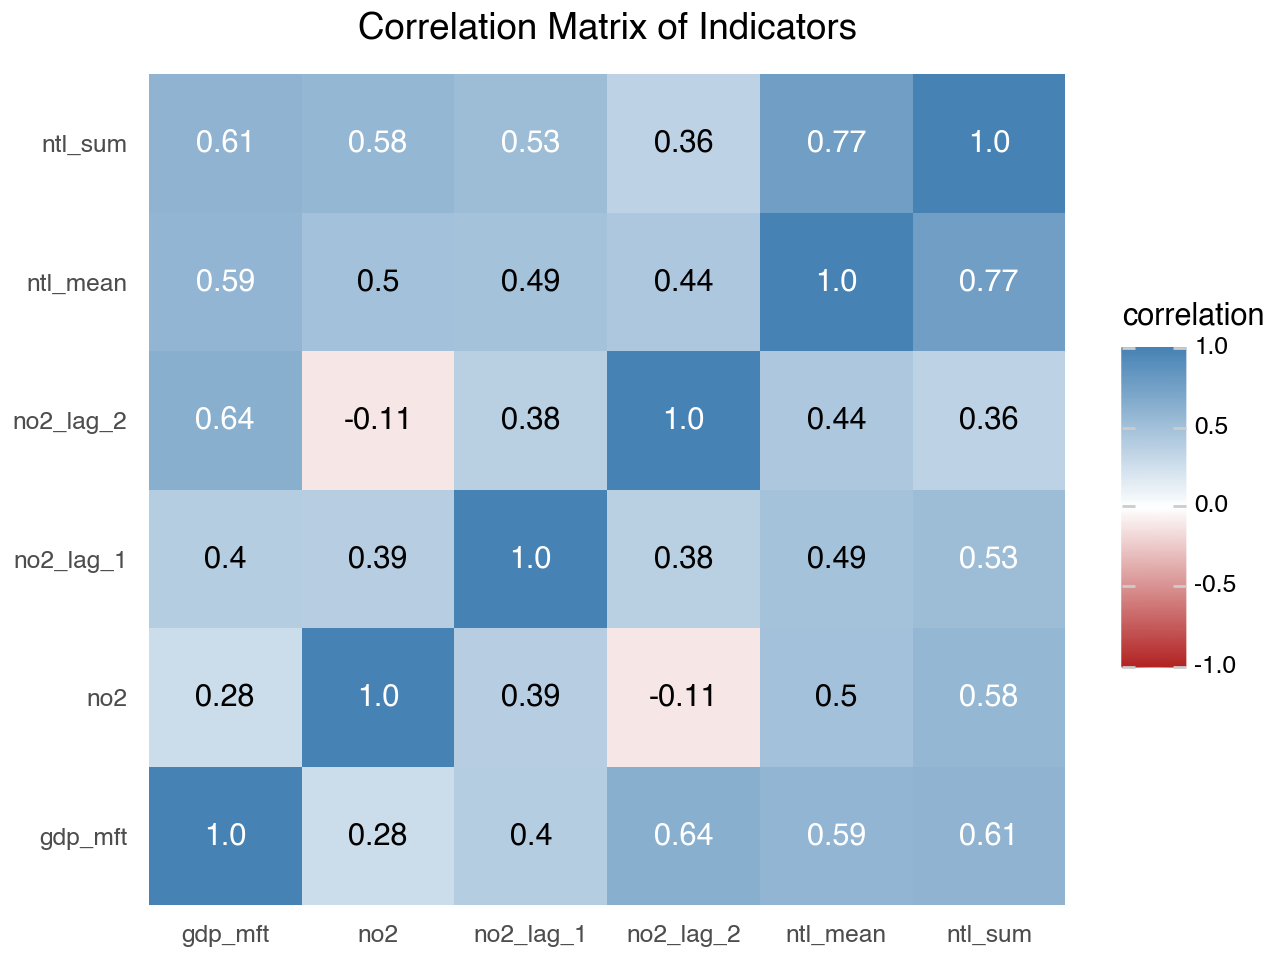

In [38]:
(
    no2_indicators_adm1.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [39]:
import numpy as np

mod_3 = smf.ols(
    "np.log(gdp_mft) ~ np.log(ntl_sum) + np.log(no2) + np.log(no2_lag_1) + np.log(no2_lag_2)",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(gdp_mft)   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     84.98
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           7.04e-52
Time:                        14:01:43   Log-Likelihood:                -526.66
No. Observations:                 396   AIC:                             1063.
Df Residuals:                     391   BIC:                             1083.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.5109      5.884      2.976      0.003       5.943      29.079
np.log(ntl_sum)       0.7792      0.067     11.650      0.000       0.648       0.911
np.log(no2)          -1.2391      0.369     -3.360      0.001      -1.964      -0.514
np.log(no2_lag_1)     0.2670      0.331      0.806      0.421      -0.384       0.918
np.log(no2_lag_2)     2.3505      0.324      7.260      0.000       1.714       2.987
==============================================================================
Omnibus:                       20.899   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.067
Skew:                          -0.336   Prob(JB):                     0.000882
Kurtosis:                       2.368   Cond. No.                     2.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

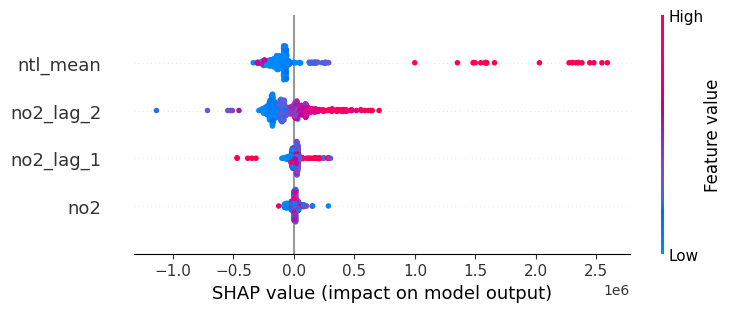

In [40]:
no2_indicators_adm_1_clean = no2_indicators_adm1.dropna()
X = no2_indicators_adm_1_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_adm_1_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

In [41]:
no2_indicators_adm_1_clean

gdp_mft       no2  ntl_mean        ntl_sum  \
adm1_name  date                                                          
Ayeyarwady 2019-07-01  5.480947e+05  0.000048  0.040248   15247.368991   
           2019-10-01  5.760143e+05  0.000047  0.031796   15631.504114   
           2020-01-01  2.529485e+05  0.000051  0.044890   22067.958199   
           2020-04-01  3.134188e+05  0.000054  0.041601   20445.657393   
           2020-07-01  5.537034e+05  0.000046  0.032073   11403.154742   
...                             ...       ...       ...            ...   
Yangon     2023-10-01  3.398282e+06  0.000084  1.341484  193872.643026   
           2024-01-01  1.480224e+06  0.000117  1.288833  248295.662349   
           2024-04-01  1.776077e+06  0.000078  1.451145  178197.192109   
           2024-07-01  3.621611e+06  0.000053  1.254324  155936.478288   
           2024-10-01  3.429651e+06  0.000083  1.215892  175752.381717   

                          gdp_mft_c   no2_std  ntl_mean_std  ntl_sum_std  \
adm1_name  date                                                            
Ayeyarwady 2019-07-01  2.068905e+05 -0.803675     -0.410158    -0.632174   
           2019-10-01  2.348101e+05 -0.872141     -0.440278    -0.622529   
           2020-01-01 -8.825577e+04 -0.529058     -0.393616    -0.460924   
           2020-04-01 -2.778548e+04 -0.257063     -0.405337    -0.501657   
           2020-07-01  2.124992e+05 -0.952865     -0.439290    -0.728694   
...                             ...       ...           ...          ...   
Yangon     2023-10-01  3.057078e+06  2.632758      4.226818     3.852709   
           2024-01-01  1.139020e+06  5.776550      4.039194     5.219149   
           2024-04-01  1.434873e+06  2.078155      4.617595     3.459133   
           2024-07-01  3.280407e+06 -0.345225      3.916221     2.900216   
           2024-10-01  3.088447e+06  2.531909      3.779268     3.397749   

                       no2_lag_1  no2_lag_2  no2_lag_1_std  no2_lag_2_std  \
adm1_name  date                                                             
Ayeyarwady 2019-07-01   0.000061   0.000056       1.490983       0.622637   
           2019-10-01   0.000048   0.000061      -0.971238       1.475625   
           2020-01-01   0.000047   0.000048      -1.110398      -1.086236   
           2020-04-01   0.000051   0.000047      -0.413061      -1.231028   
           2020-07-01   0.000054   0.000051       0.139786      -0.505471   
...                          ...        ...            ...            ...   
Yangon     2023-10-01   0.000061   0.000082      -0.842427       0.240989   
           2024-01-01   0.000084   0.000061       0.380219      -0.915259   
           2024-04-01   0.000117   0.000084       2.129763       0.327460   
           2024-07-01   0.000078   0.000117       0.071578       2.105729   
           2024-10-01   0.000053   0.000078      -1.277053       0.013752   

                       ntl_mean_lag_1  
adm1_name  date                        
Ayeyarwady 2019-07-01        0.041915  
           2019-10-01        0.040248  
           2020-01-01        0.031796  
           2020-04-01        0.044890  
           2020-07-01        0.041601  
...                               ...  
Yangon     2023-10-01        1.371373  
           2024-01-01        1.341484  
           2024-04-01        1.288833  
           2024-07-01        1.451145  
           2024-10-01        1.254324  

[396 rows x 13 columns]